Looking at a dynamic programming solution for the case of ["next card bet"](https://github.com/WinVector/Examples/blob/main/puzzles/next_card_bet/Kelly_cant_fail.ipynb) with invisible stakes.

In [1]:
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
from plotnine import *
from card_count_fns import (
    basic_bet_strategy,
    dynprog_bet_strategy,
    find_worst_deck,
    k_array_with_t_true,
    minmax_bet_value,
    mk_traj_frame,
    run_bets,
    run_bets_int,
    theoretical_payout,
    )

In [2]:
rng = np.random.default_rng(2024)

In [3]:
initial_stake = 100
n_cards_per_color = 26


In [4]:
ideal_return = theoretical_payout(n_cards_per_color, n_cards_per_color)

ideal_return

9.08132954942779

In [5]:
bad_basic_deck = find_worst_deck(
    initial_stake, n_cards_per_color, n_cards_per_color, 
    satiation_point=None, bet_strategy=basic_bet_strategy)

bad_basic_deck

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True])

In [6]:
run_bets_int(
        bad_basic_deck,
        initial_stake=initial_stake,
        satiation_point=None,
        bet_strategy=basic_bet_strategy,
    )

(0.02,
 array([100, 100,  98,  94,  88,  81,  72,  63,  53,  43,  34,  26,  19,
         13,   9,   6,   4,   2,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          2]))

In [7]:
satiation_point = int(np.ceil(ideal_return * initial_stake))

In [8]:

# compute dynamic programming minmax value
min_payoff_constrained = minmax_bet_value(
    initial_stake, n_cards_per_color, n_cards_per_color, satiation_point,
)
min_empirical_return_rate = min_payoff_constrained / initial_stake
min_empirical_return_rate

8.08

In [9]:
run_bets_int(
        bad_basic_deck,
        initial_stake=initial_stake,
        satiation_point=satiation_point,
        bet_strategy=dynprog_bet_strategy,
    )

(60747.52,
 array([    100,     100,      98,      94,      89,      82,      74,
             66,      57,      48,      40,      33,      26,      20,
             16,      13,      11,      10,       9,       8,       7,
              6,       5,       4,       3,       2,       3,       5,
              9,      17,      32,      61,     116,     220,     417,
            788,    1483,    2781,    5191,    9640,   17797,   32628,
          59324,  106783,  189836,  332213,  569508,  949180, 1518688,
        2278032, 3037376, 3037376, 6074752]))

In [10]:
bad_dynprog_deck = find_worst_deck(
    initial_stake, n_cards_per_color, n_cards_per_color, 
    satiation_point=satiation_point, bet_strategy=dynprog_bet_strategy)

bad_dynprog_deck

array([False, False, False, False, False, False,  True,  True,  True,
        True, False, False, False, False,  True,  True,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False, False,  True,  True, False,  True,  True, False,  True,
       False, False,  True,  True, False, False,  True,  True,  True,
       False,  True, False, False,  True,  True,  True])

In [11]:
run_bets_int(
        bad_dynprog_deck,
        initial_stake=initial_stake,
        satiation_point=satiation_point,
        bet_strategy=basic_bet_strategy,
    )

(8.96,
 array([100, 100,  98,  94,  88,  81,  72,  81,  90,  98, 105, 100,  93,
         84,  73,  85,  96, 107,  98, 110, 100, 112, 101, 114, 102, 117,
        104, 120, 106,  88, 107, 126, 108, 130, 151, 134, 158, 138, 110,
        141, 174, 145, 105, 147, 196, 245, 210, 280, 224, 112, 224, 448,
        896]))

In [12]:
run_bets_int(
        bad_dynprog_deck,
        initial_stake=initial_stake,
        satiation_point=satiation_point,
        bet_strategy=dynprog_bet_strategy,
    )

(8.08,
 array([100, 100,  98,  94,  89,  82,  74,  82,  90,  97, 103,  98,  91,
         83,  73,  83,  93, 102,  94, 104,  95, 106,  96, 108,  97, 110,
         98, 112,  99,  83, 100, 117, 101, 120, 138, 123, 144, 126, 101,
        129, 158, 132,  96, 134, 178, 222, 190, 253, 202, 101, 202, 404,
        808]))

In [13]:
decks = [
    k_array_with_t_true(2 * n_cards_per_color, n_cards_per_color, rng=rng)
    for _ in range(10000)
]

In [14]:
payoffs_basic = [
    run_bets_int(
        deck,
        initial_stake=initial_stake,
        satiation_point=None,
        bet_strategy=basic_bet_strategy,
    )[0]
    for deck in decks
]

(np.min(payoffs_basic), np.mean(payoffs_basic), np.max(payoffs_basic))

(0.02, 9.083892, 40.96)

In [15]:
assert np.min(payoffs_basic) > 0

In [16]:
np.std(payoffs_basic)

0.4642585188620667

In [17]:
plt_frame_basic = pd.DataFrame({"return": payoffs_basic, "strategy": "basic"})

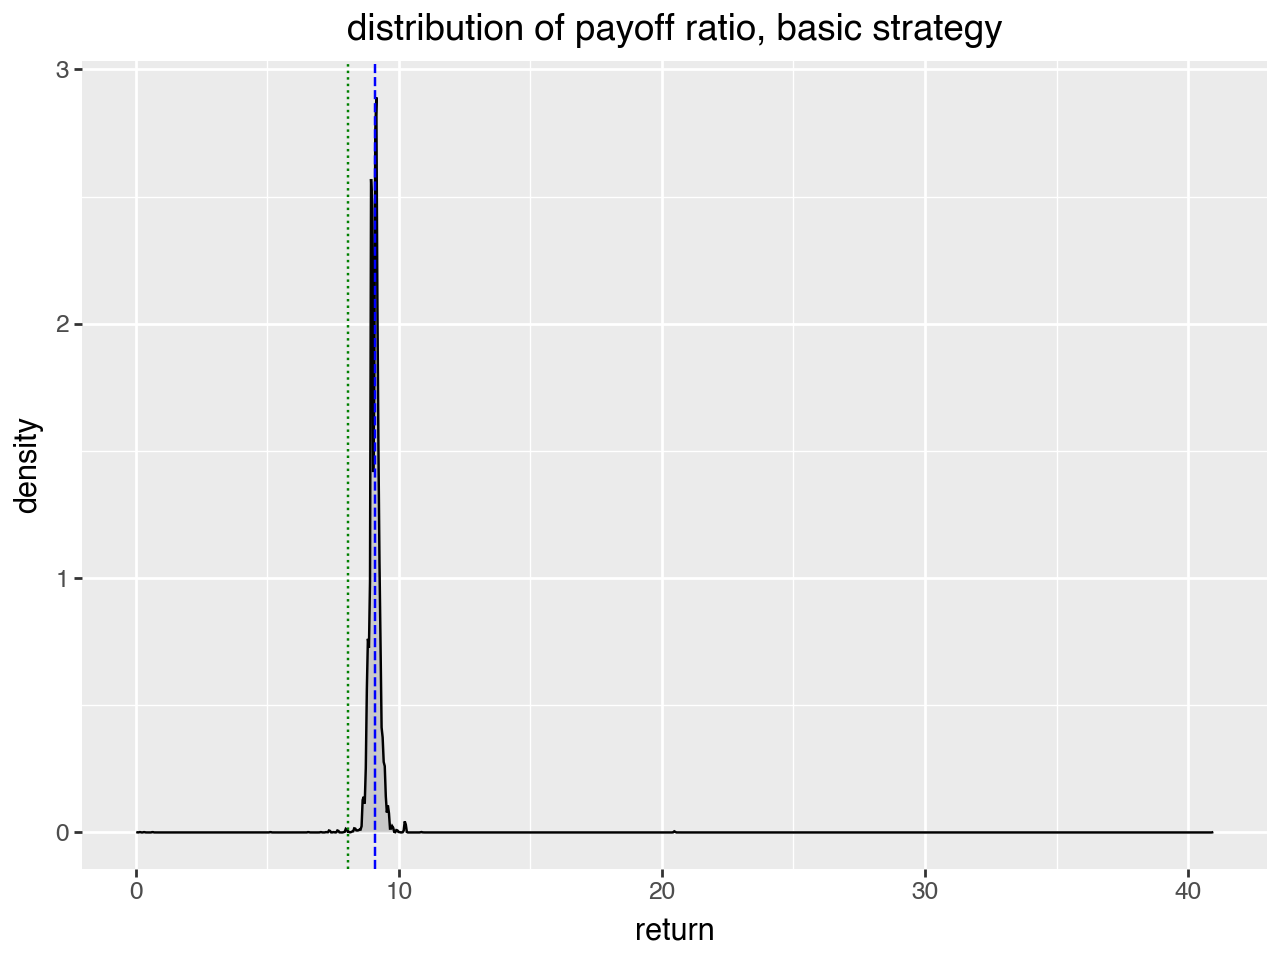

In [18]:
(
    ggplot(data=plt_frame_basic, mapping=aes(x="return"))
    + geom_density(fill="darkgray", alpha=0.5, trim=True)
    + geom_vline(xintercept=min_empirical_return_rate, color="green", linetype="dotted")
    + geom_vline(xintercept=ideal_return, color="blue", linetype="--")
    + ggtitle("distribution of payoff ratio, basic strategy")
)

In [19]:
payoffs_dynprog = [
    run_bets_int(
        deck,
        initial_stake=initial_stake,
        satiation_point=satiation_point,
        bet_strategy=dynprog_bet_strategy,
    )[0]
    for deck in decks
]
assert np.min(payoffs_dynprog) >= min_empirical_return_rate

(np.min(payoffs_dynprog), np.mean(payoffs_dynprog), np.max(payoffs_dynprog))

(8.26, 9.075486, 40.96)

In [20]:
assert np.min(payoffs_dynprog) > 0

In [21]:
np.std(payoffs_dynprog)

0.6745429147237408

In [22]:
plt_frame_dynprog = pd.DataFrame({"return": payoffs_dynprog, "strategy": "dynprog"})


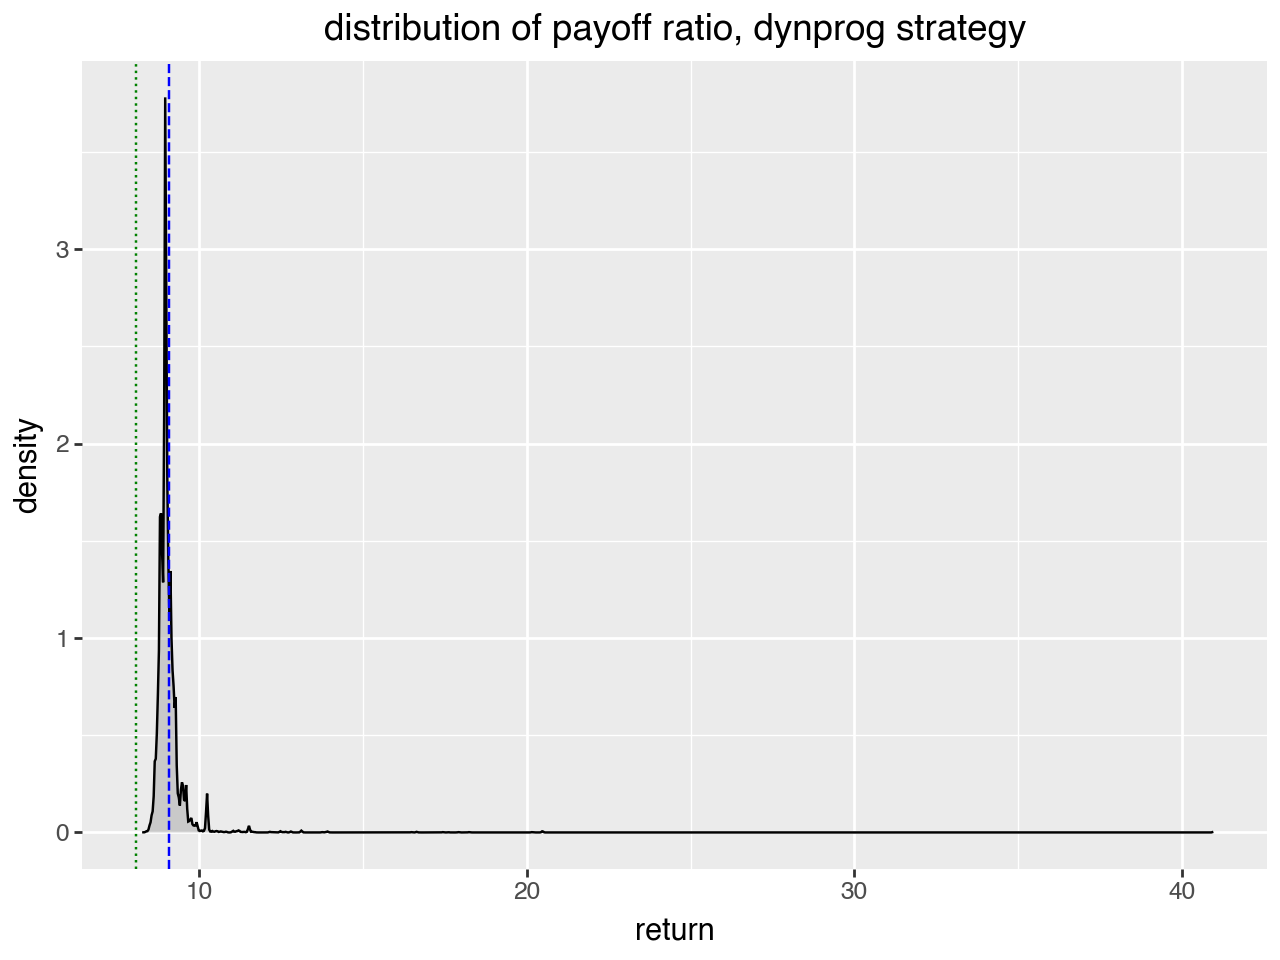

In [23]:
(
    ggplot(data=plt_frame_dynprog, mapping=aes(x="return"))
    + geom_density(fill="darkgray", alpha=0.5, trim=True)
    + geom_vline(xintercept=min_empirical_return_rate, color="green", linetype="dotted")
    + geom_vline(xintercept=ideal_return, color="blue", linetype="--")
    + ggtitle("distribution of payoff ratio, dynprog strategy")
)

In [24]:
plt_frame_both = pd.concat(
    [
        plt_frame_basic,
        plt_frame_dynprog,
    ],
    ignore_index=True,
)
plt_lower_bound = np.quantile(plt_frame_both["return"], 0.001)
plt_upper_bound = np.quantile(plt_frame_both["return"], 0.995)

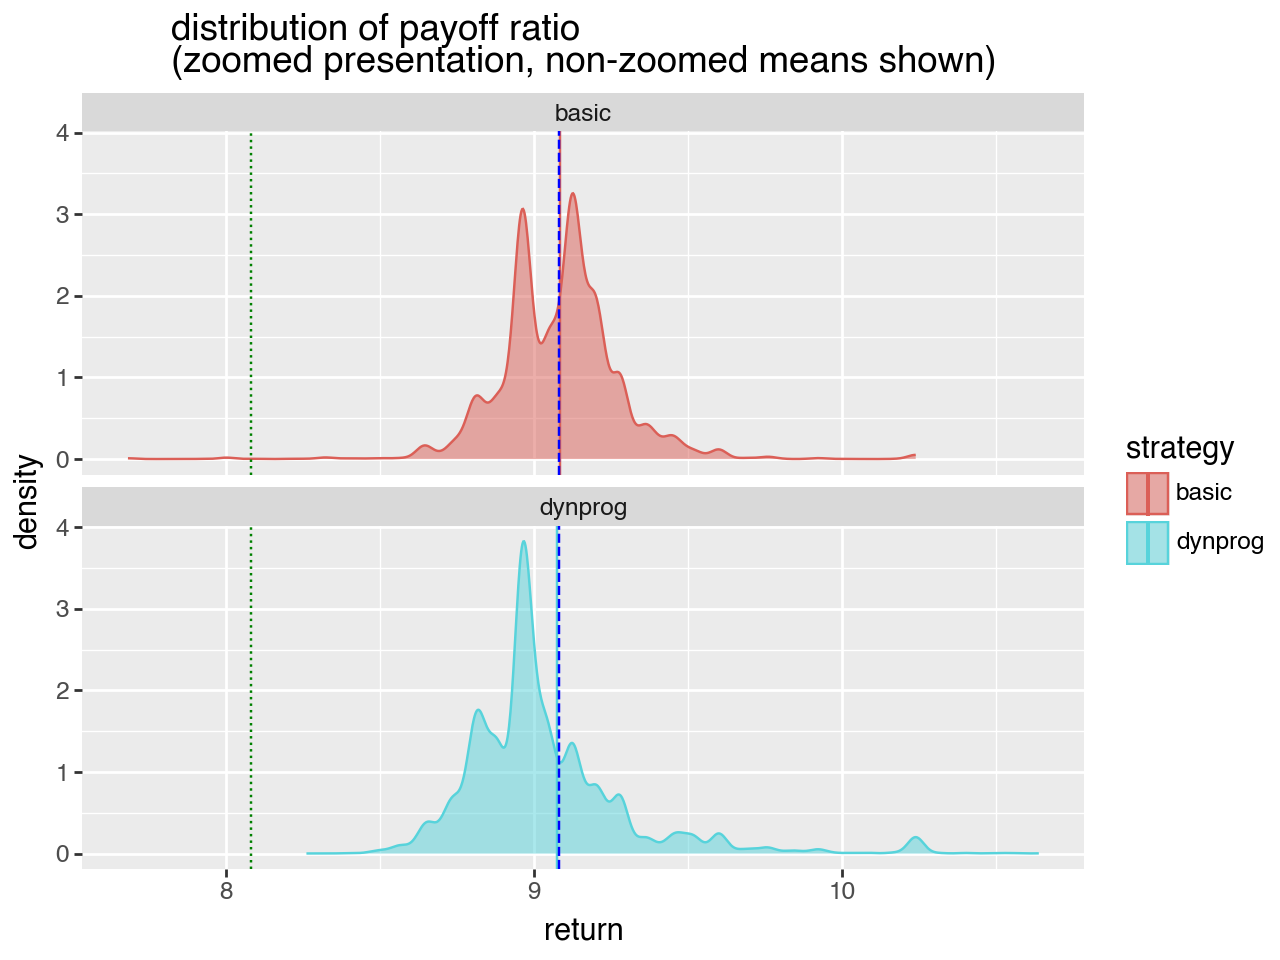

In [25]:
means_both = (
    plt_frame_both.groupby(["strategy"]).mean().reset_index(drop=False, inplace=False)
)
(
    ggplot(
        data=plt_frame_both.loc[
            (plt_frame_both["return"] >= plt_lower_bound)
            & (plt_frame_both["return"] <= plt_upper_bound),
            :,
        ],
        mapping=aes(x="return", color="strategy", fill="strategy"),
    )
    + geom_density(alpha=0.5, trim=True)
    + geom_vline(data=means_both, mapping=aes(xintercept="return", color="strategy"))
    + geom_vline(xintercept=min_empirical_return_rate, color="green", linetype="dotted")
    + geom_vline(xintercept=ideal_return, color="blue", linetype="--")
    + facet_wrap("strategy", ncol=1)
    + ggtitle(
        "distribution of payoff ratio\n(zoomed presentation, non-zoomed means shown)"
    )
)

In [26]:
# overall stats
(plt_frame_both.groupby(["strategy"]).agg(["mean", "std"]))

return          
              mean       std
strategy                    
basic     9.083892  0.464282
dynprog   9.075486  0.674577

In [27]:
# zoomed stats
(
    plt_frame_both.loc[
        (plt_frame_both["return"] >= plt_lower_bound)
        & (plt_frame_both["return"] <= plt_upper_bound),
        :,
    ]
    .groupby(["strategy"])
    .agg(["mean", "std"])
)

return          
              mean       std
strategy                    
basic     9.082854  0.196844
dynprog   9.035601  0.272613

In [28]:
compare_frame = pd.DataFrame(
    {
        "basic": payoffs_basic,
        "dynprog": payoffs_dynprog,
    }
)

In [29]:
np.min(compare_frame["basic"])

0.02

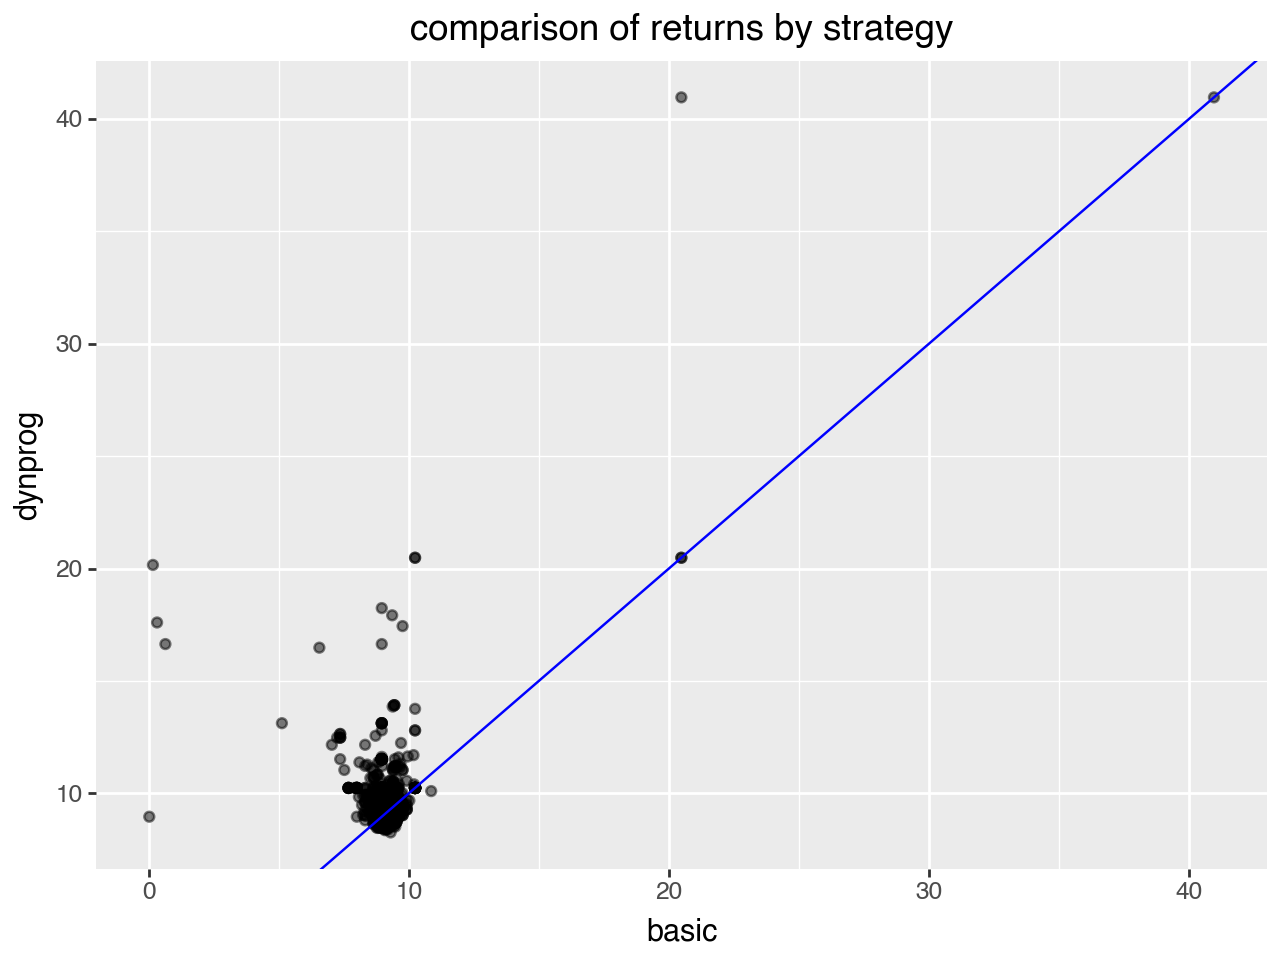

In [30]:
(
    ggplot(data=compare_frame, mapping=aes(x="basic", y="dynprog"))
    + geom_point(alpha=0.5)
    + geom_abline(intercept=0, slope=1, color="blue")
    + ggtitle("comparison of returns by strategy")
)

In [31]:
trajectories = [
    mk_traj_frame(
        i,
        bet_strategy=basic_bet_strategy,
        initial_stake=initial_stake,
        decks=decks,
        satiation_point=satiation_point,
    )
    for i in range(1000)
] + [
    mk_traj_frame(
        i,
        bet_strategy=dynprog_bet_strategy,
        initial_stake=initial_stake,
        decks=decks,
        satiation_point=satiation_point,
    )
    for i in range(1000)
]
trajectories = pd.concat(trajectories, ignore_index=True)

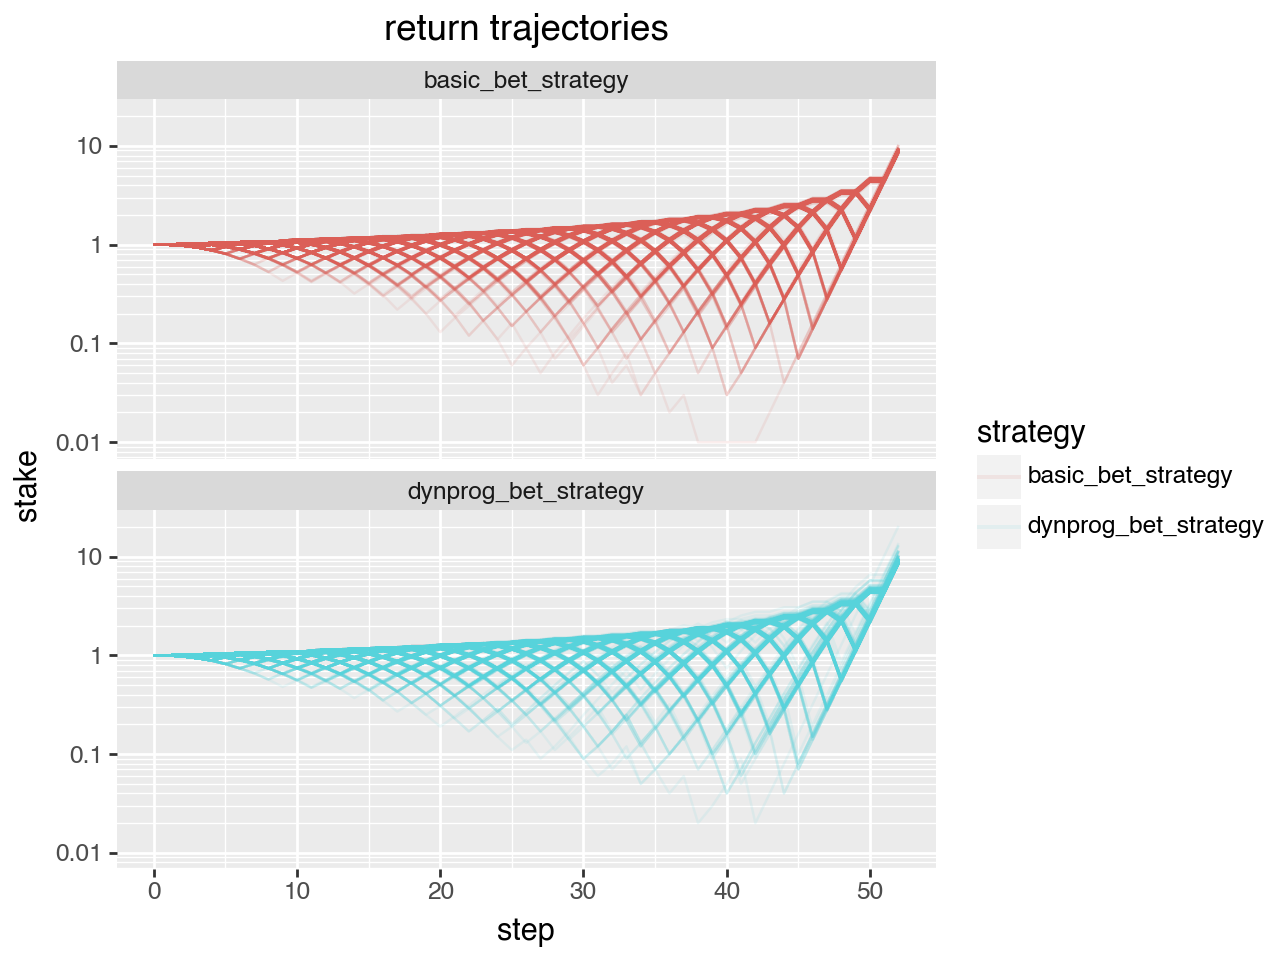

In [32]:
(
    ggplot(
        data=trajectories,
        mapping=aes(x="step", y="stake", color="strategy", group="trajectory"),
    )
    + geom_line(alpha=0.1)
    + scale_y_continuous(trans="log10")
    + facet_wrap("strategy", ncol=1)
    + ggtitle("return trajectories")
)

In [33]:
def mk_traj_frame_Kelly(i, *, decks):
    traj = []
    run_bets(decks[i], trajectory=traj)
    return pd.DataFrame(
        {
            "step": range(len(traj)),
            "stake": traj,
            "strategy": "Kelly",
            "trajectory": i,
        }
    )

In [34]:
trajectories_Kelly = pd.concat([
    mk_traj_frame_Kelly(
        i,
        decks=decks,
    )
    for i in range(1000)
], ignore_index=True)

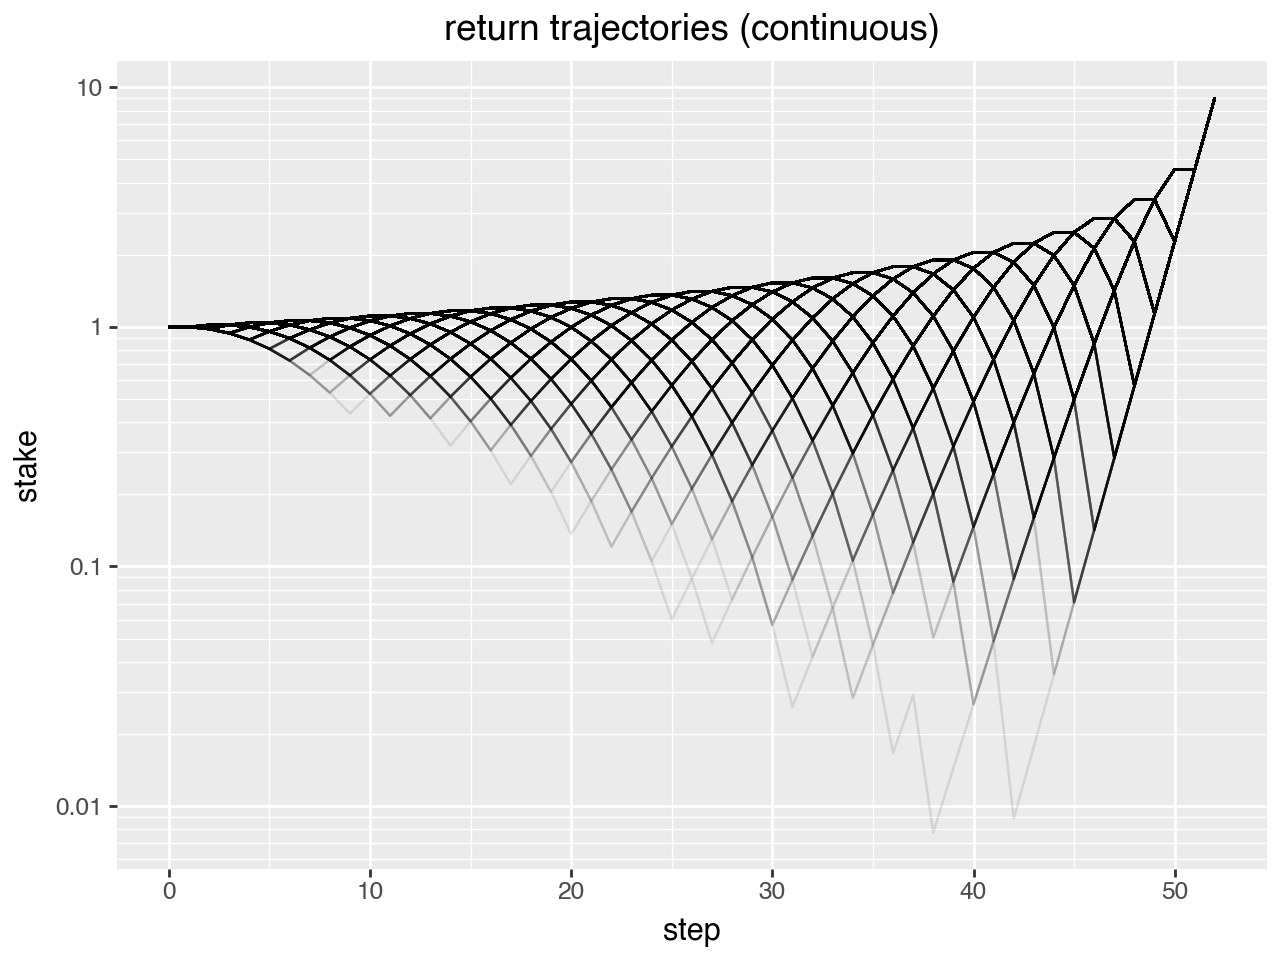

In [35]:
(
    ggplot(
        data=trajectories_Kelly,
        mapping=aes(x="step", y="stake", group="trajectory"),
    )
    + geom_line(alpha=0.1)
    + scale_y_continuous(trans="log10")
    + ggtitle("return trajectories (continuous)")
)

In [36]:

def plot_comparative_strategies(b: int, r: int):
    start_frame = pd.DataFrame({
        'stake': range(initial_stake),
        'dynprog': [ dynprog_bet_strategy(i, b, r, satiation_point) for i in range(initial_stake) ],
        'basic': [ basic_bet_strategy(i, b, r) for i in range(initial_stake) ],
    })
    return (
        ggplot(
            data=start_frame,
            mapping=aes(x='stake')
        )
        + geom_line(mapping=aes(y='basic'), color='blue')
        + geom_point(mapping=aes(y='dynprog'), color='green')
        + ggtitle(f"basic and dynprog bidding for ({b} black remaining, {r} red remaining)")
    )

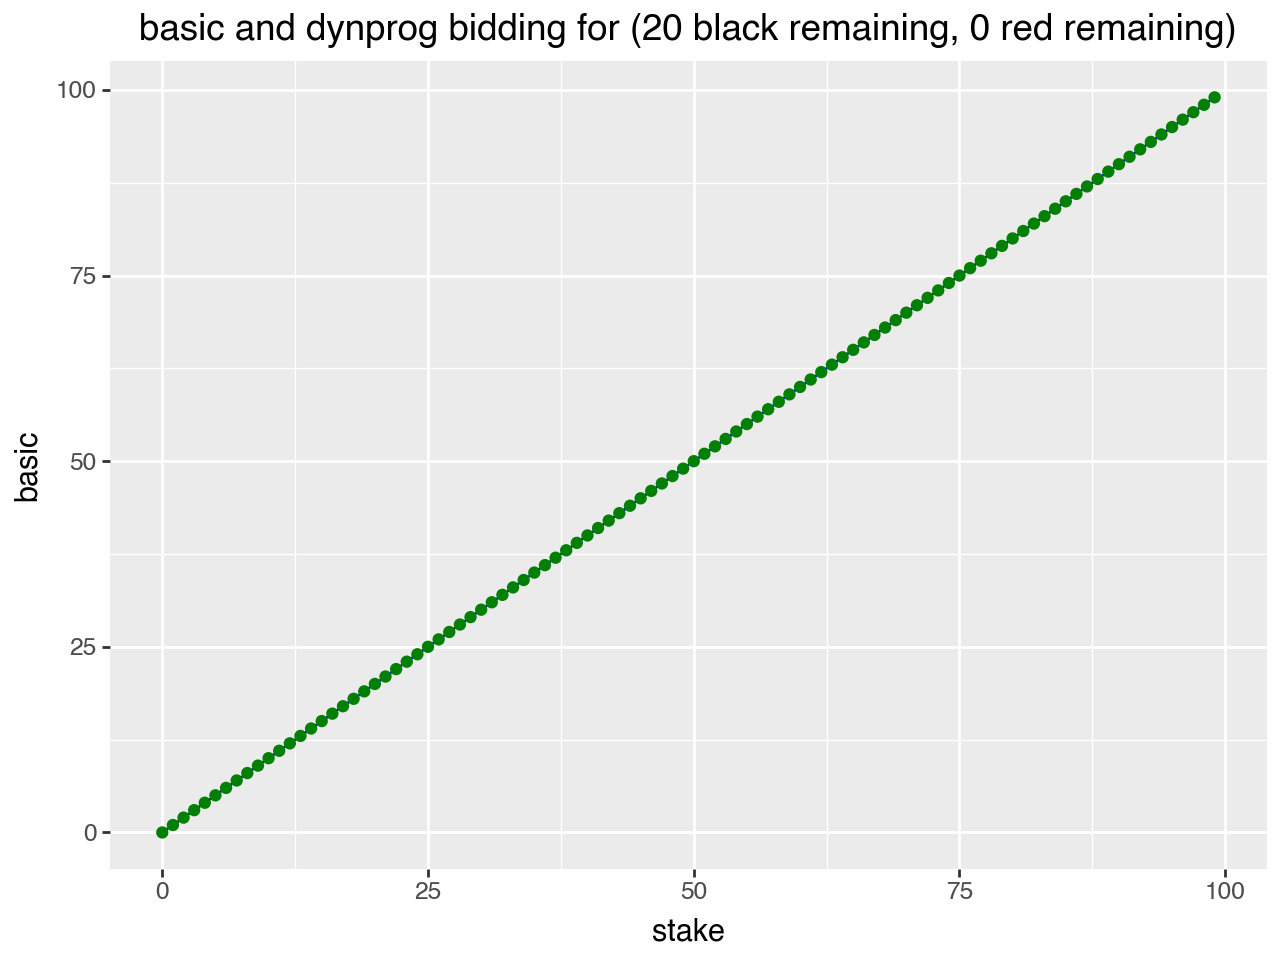

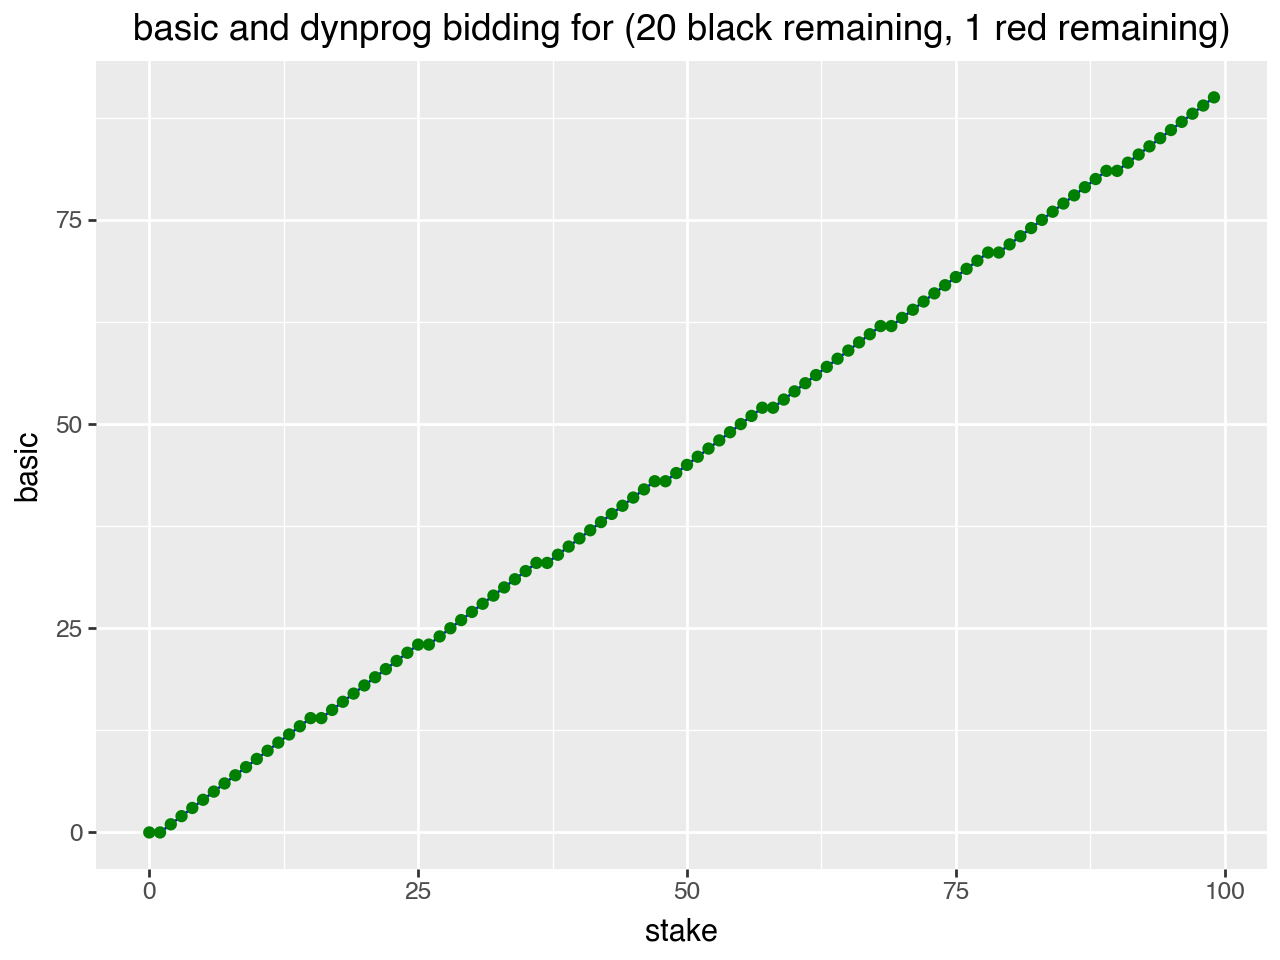

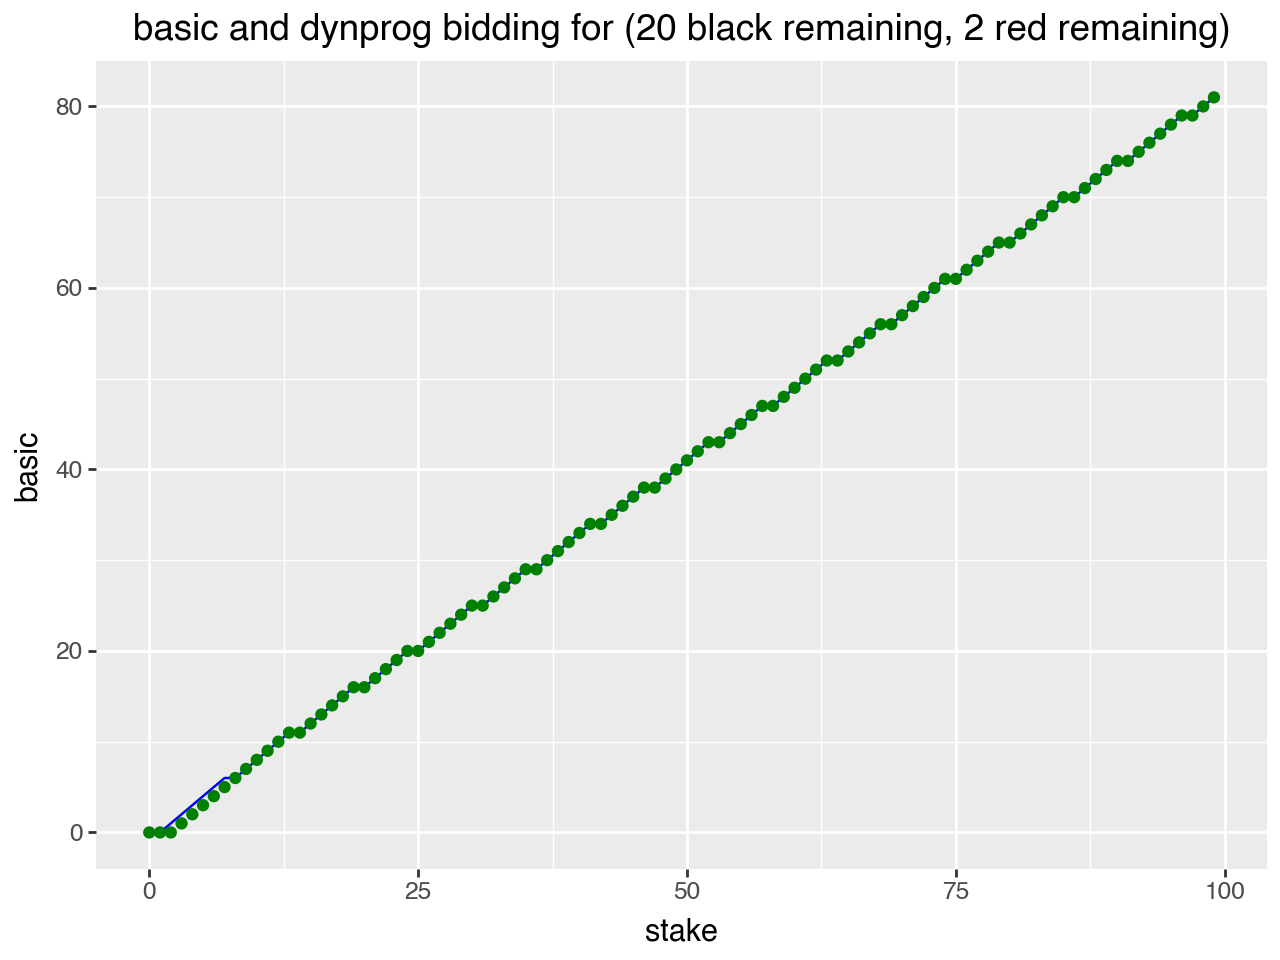

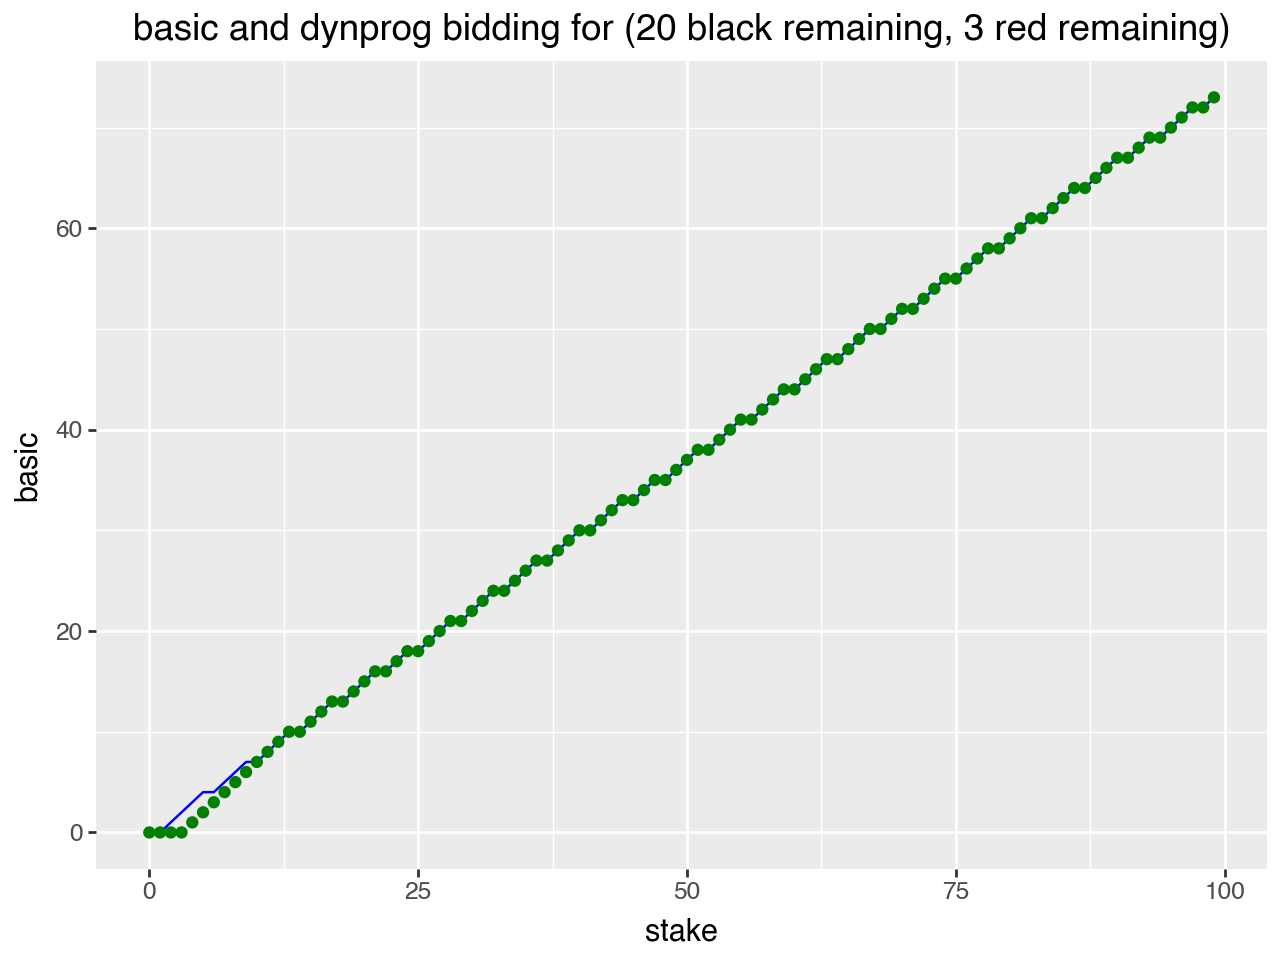

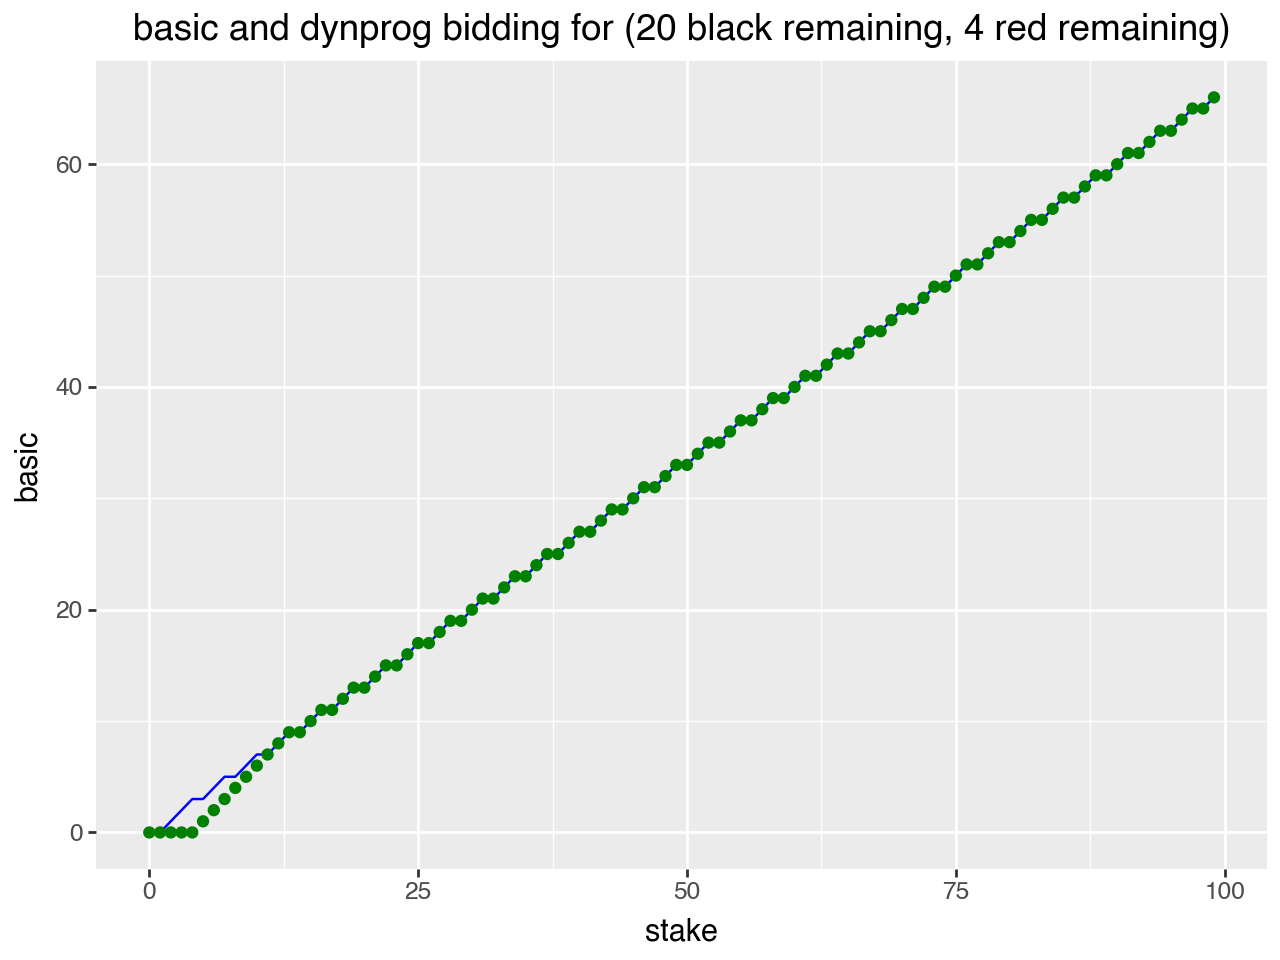

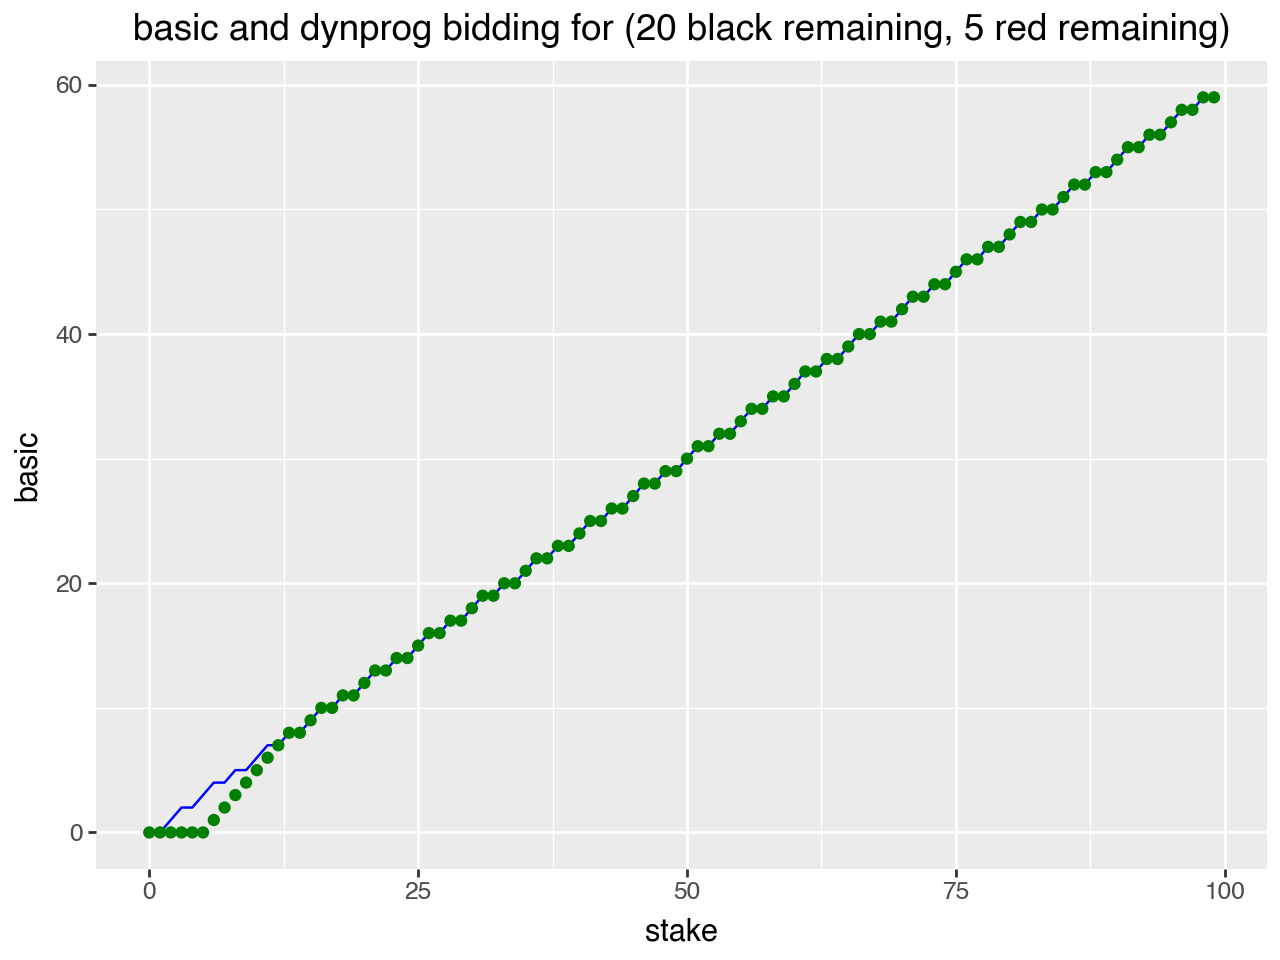

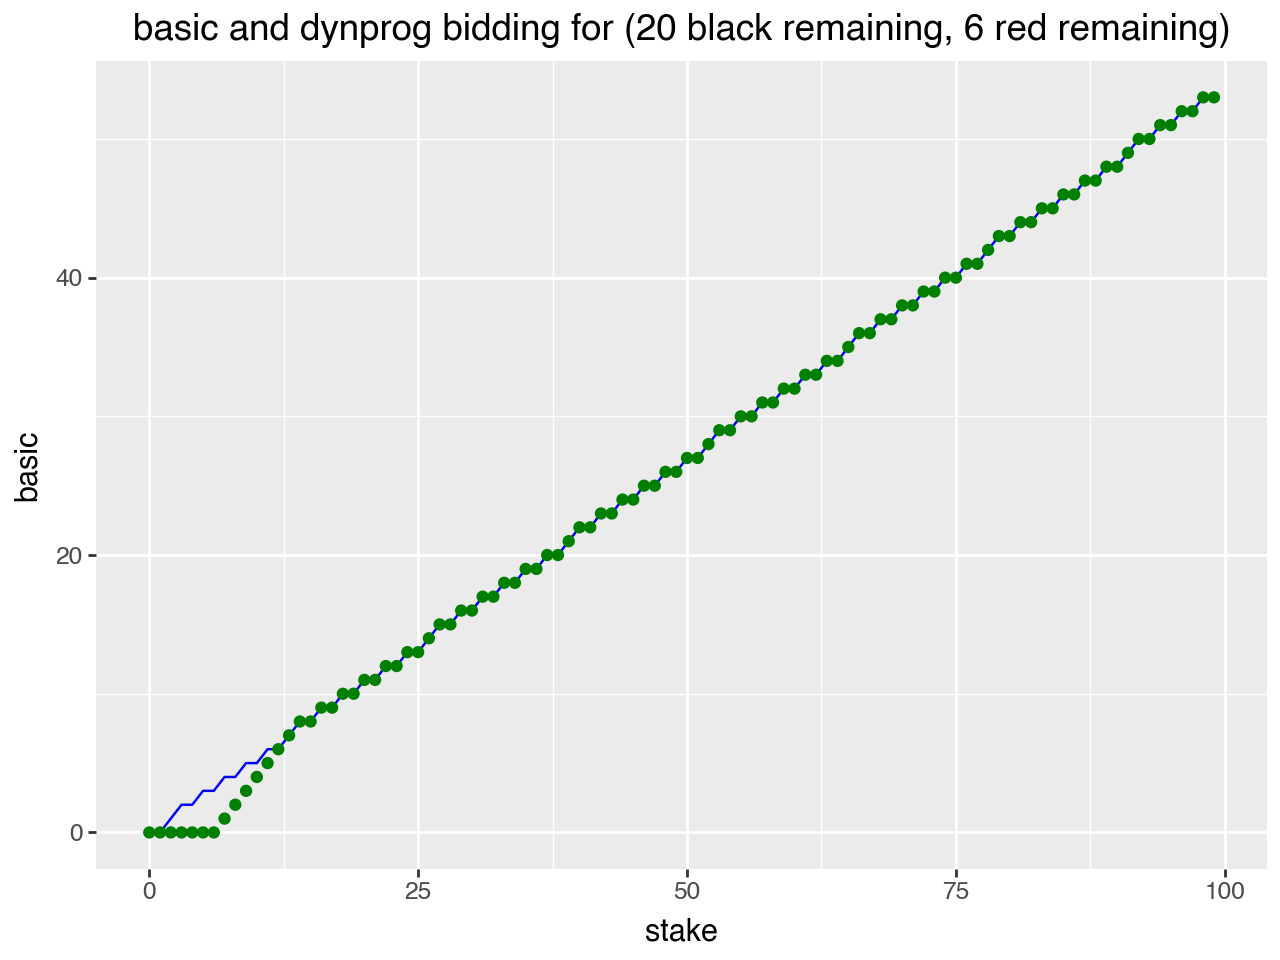

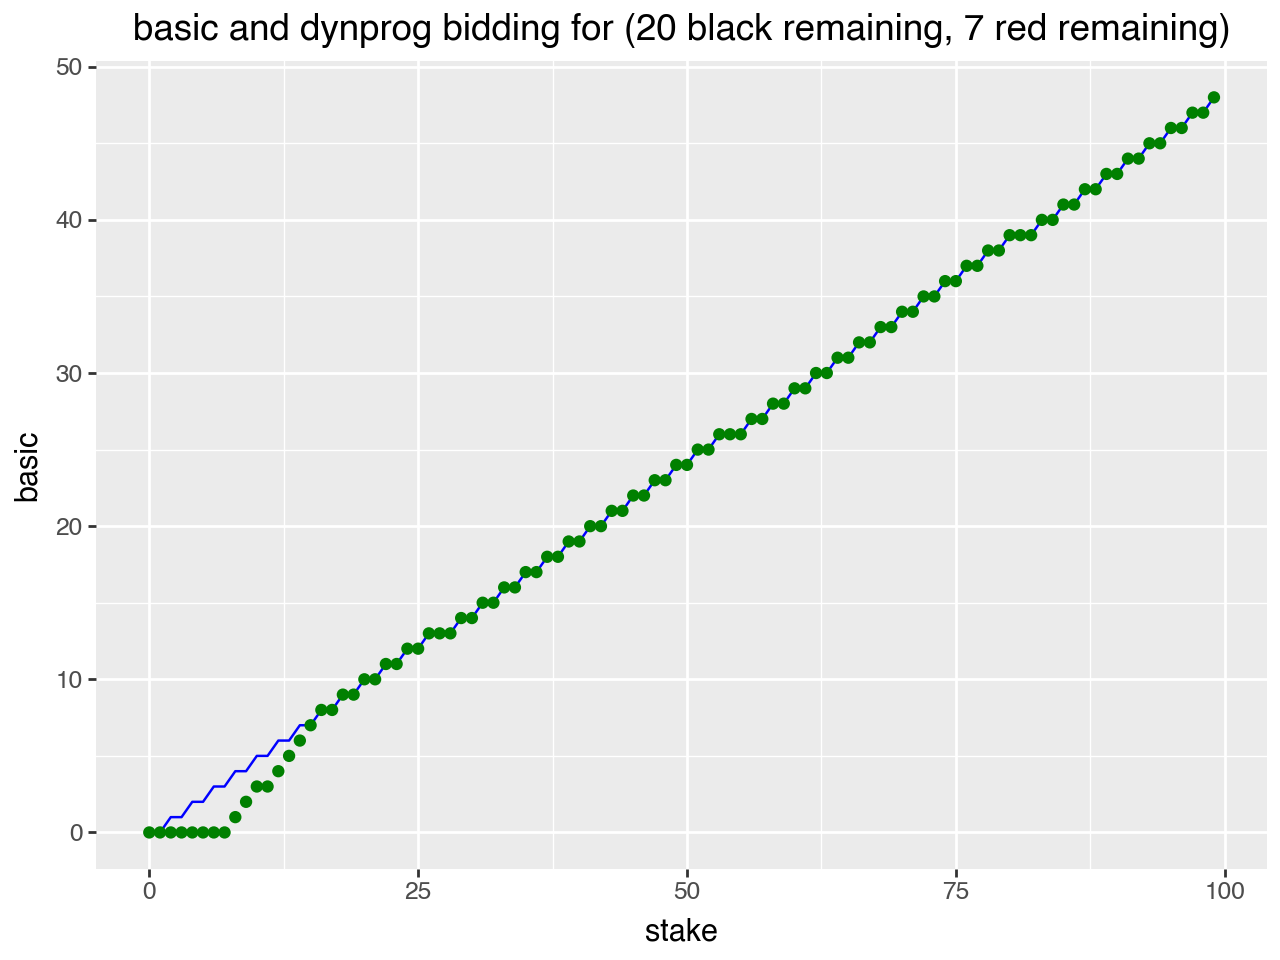

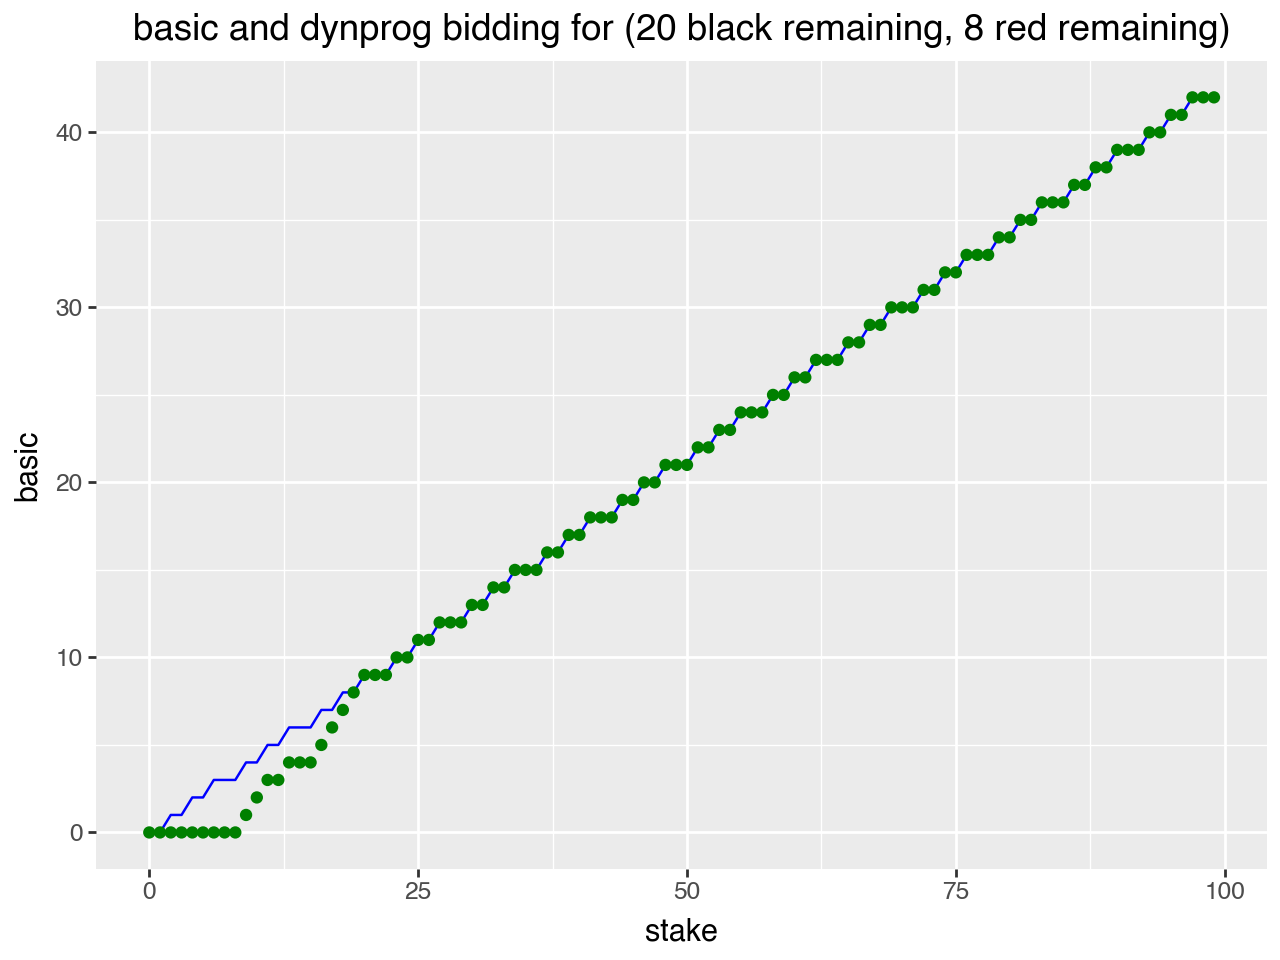

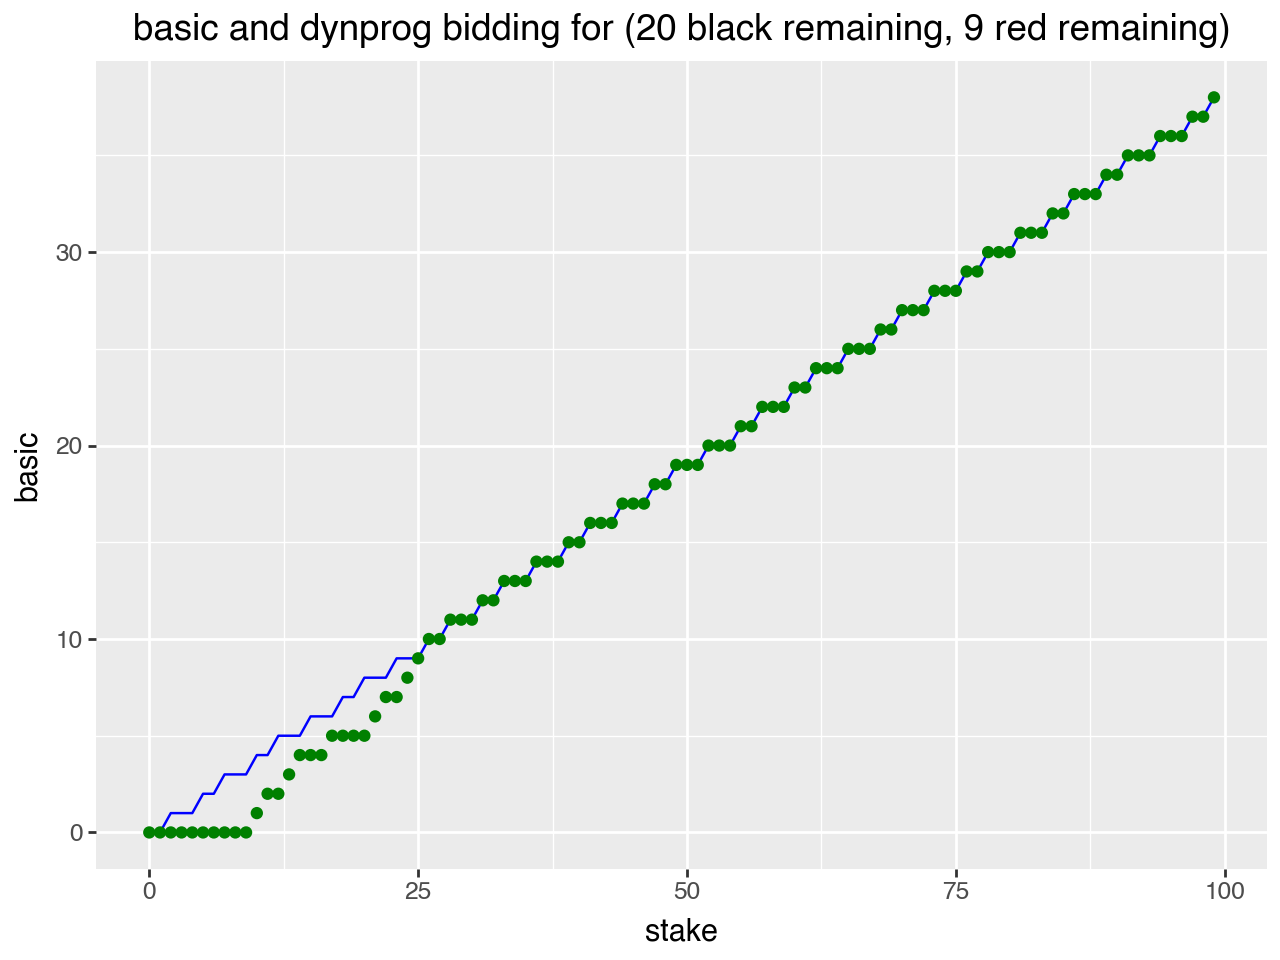

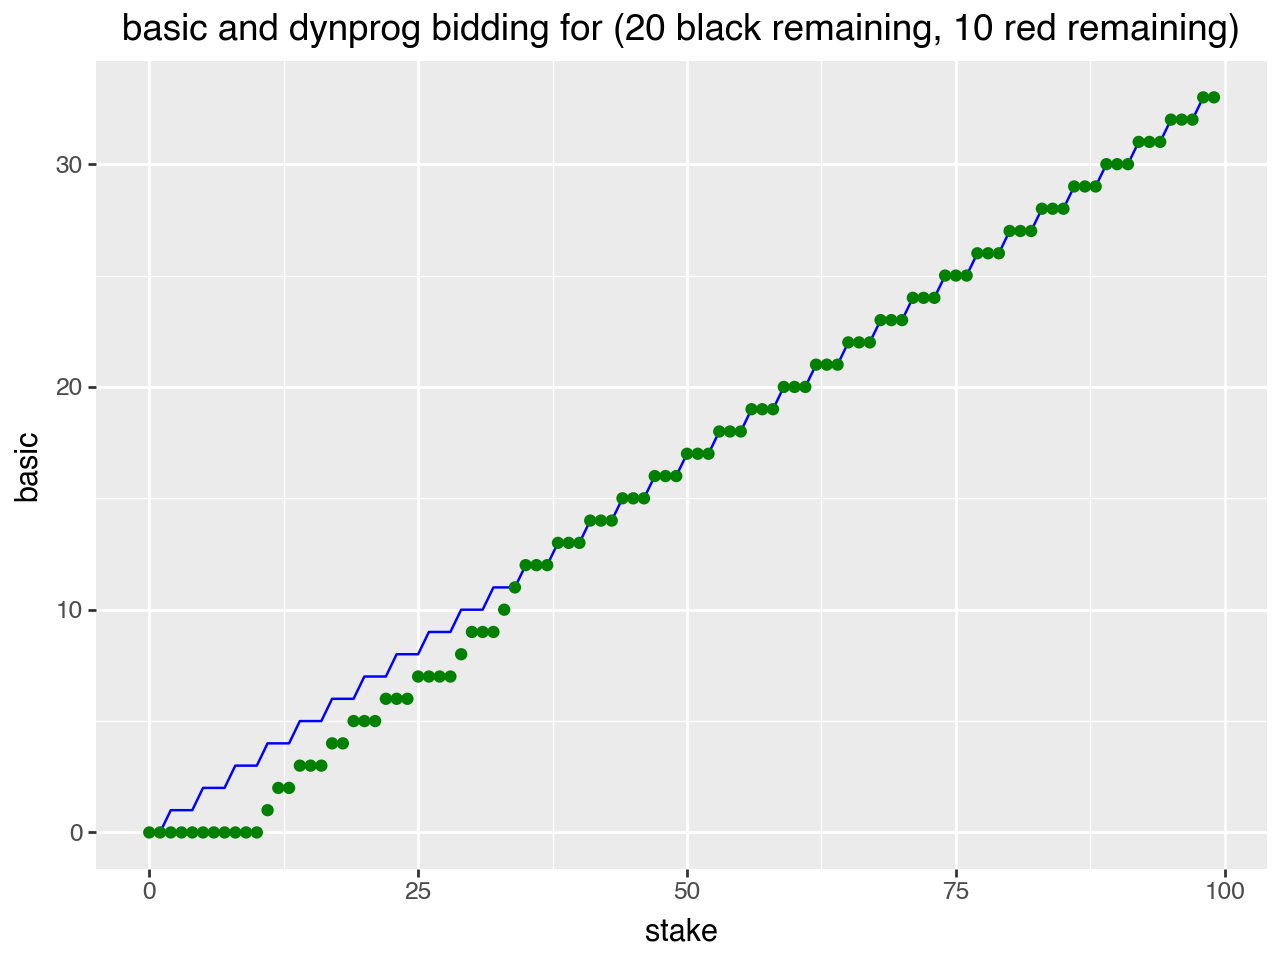

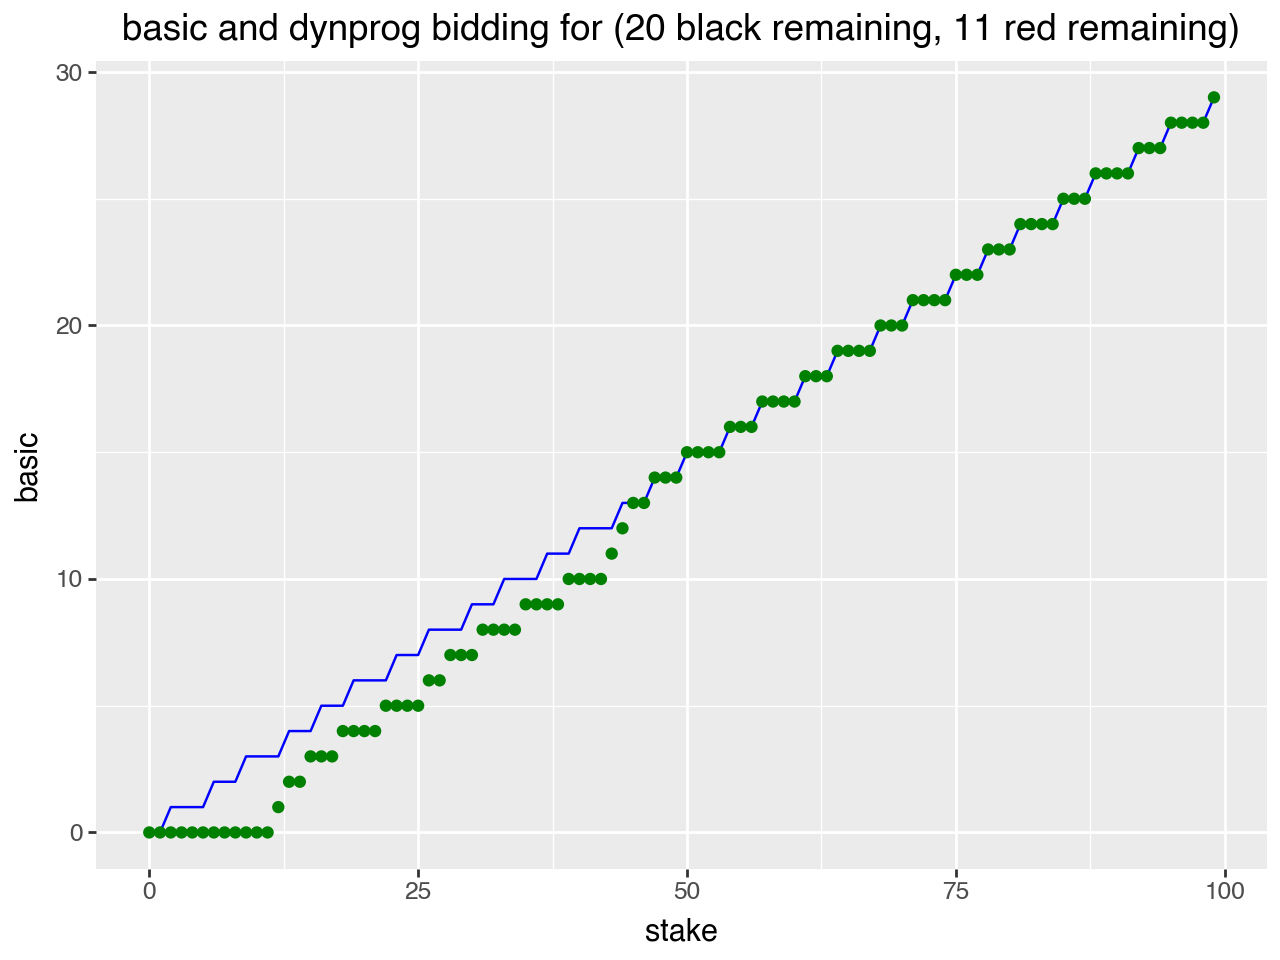

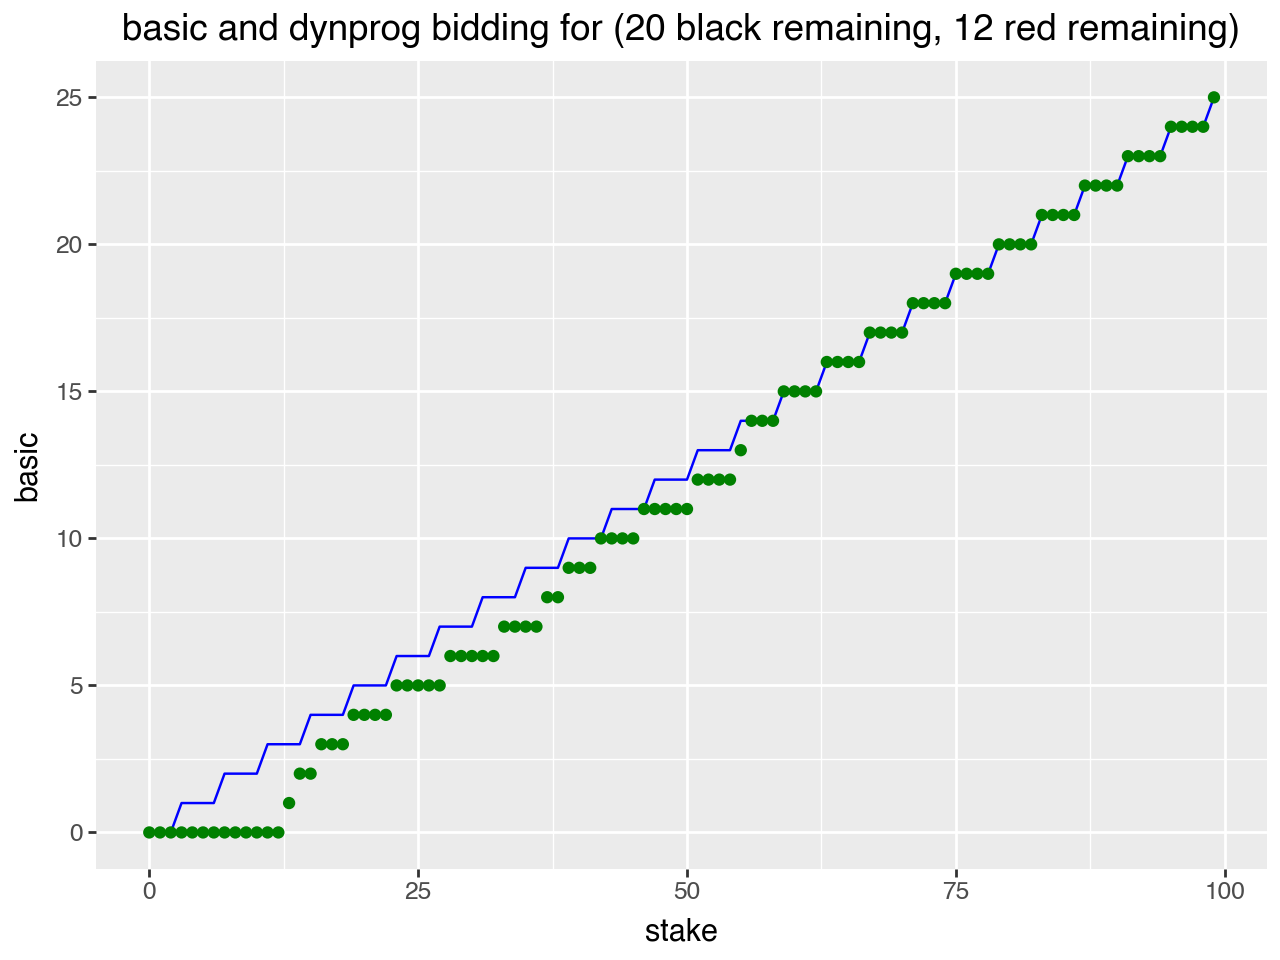

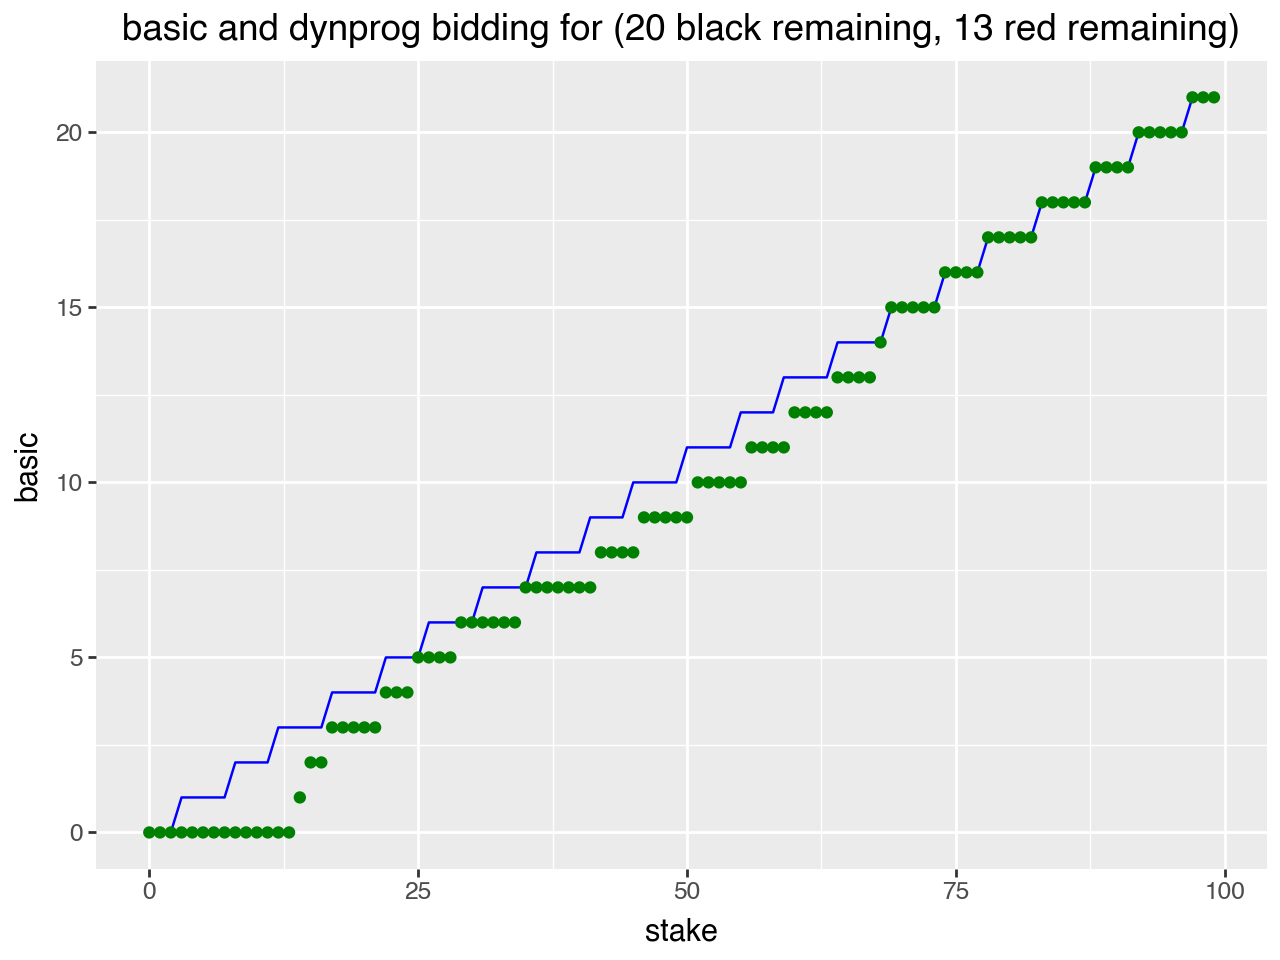

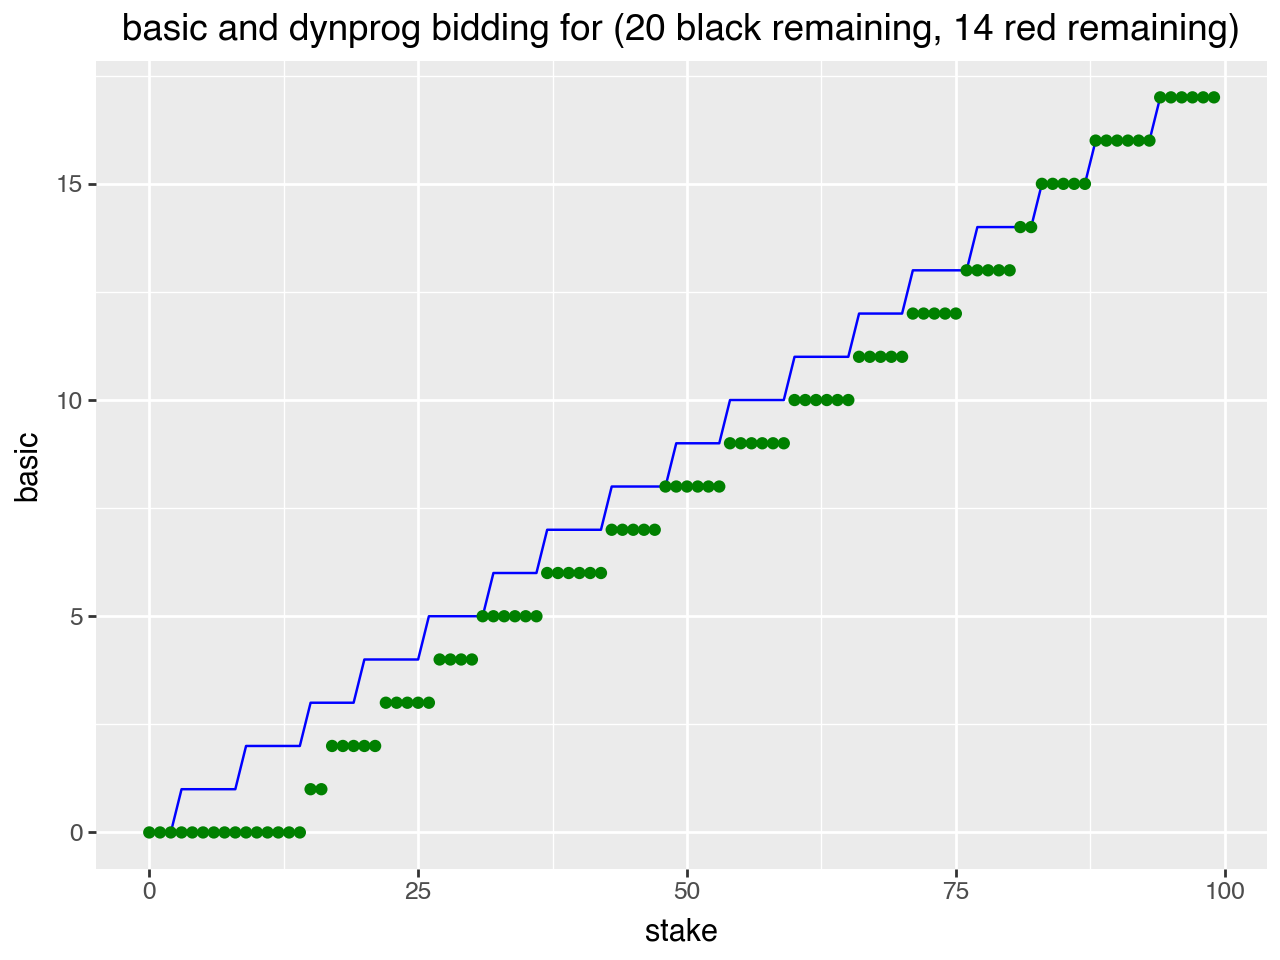

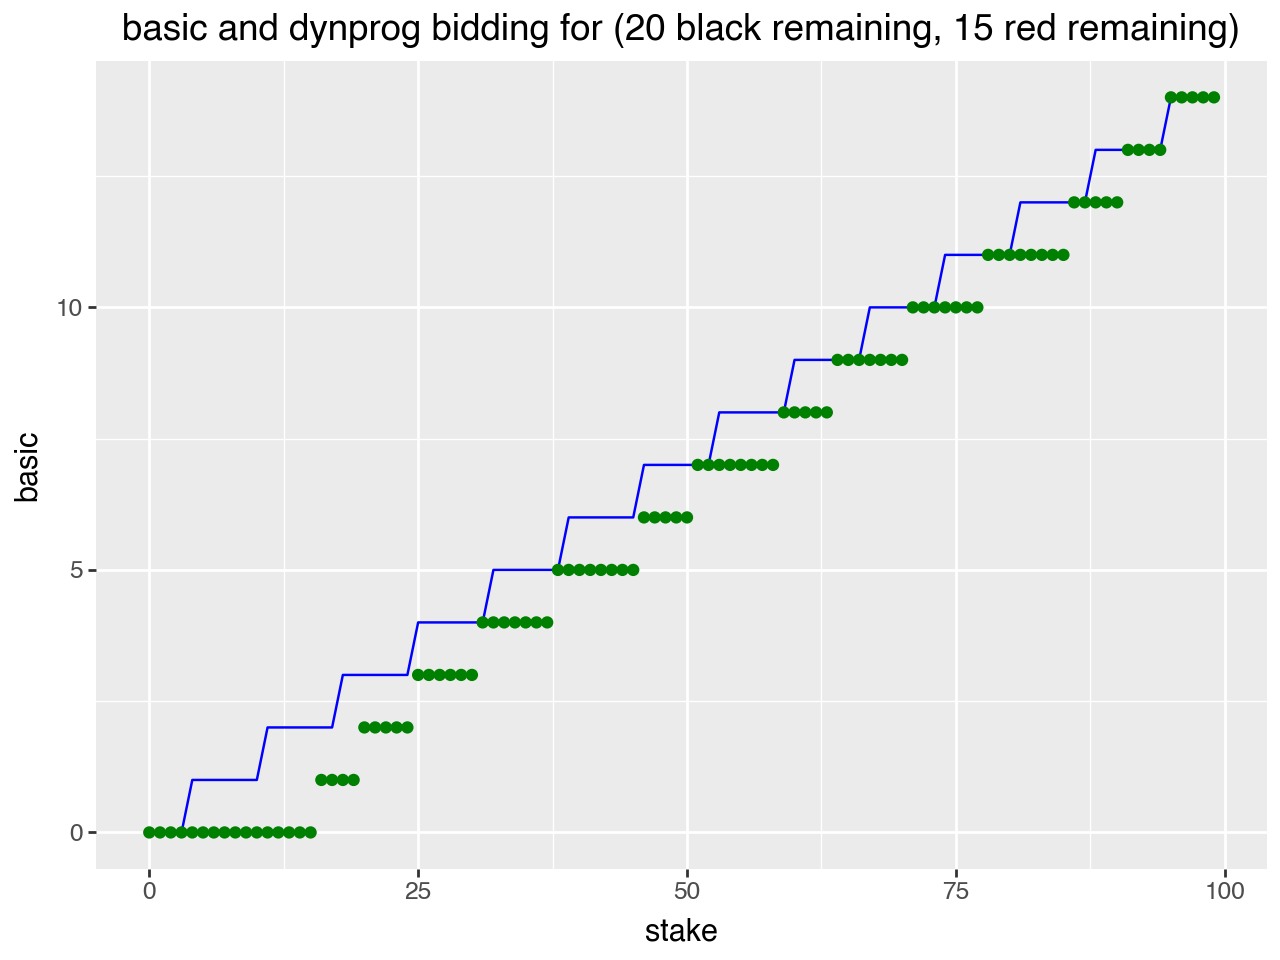

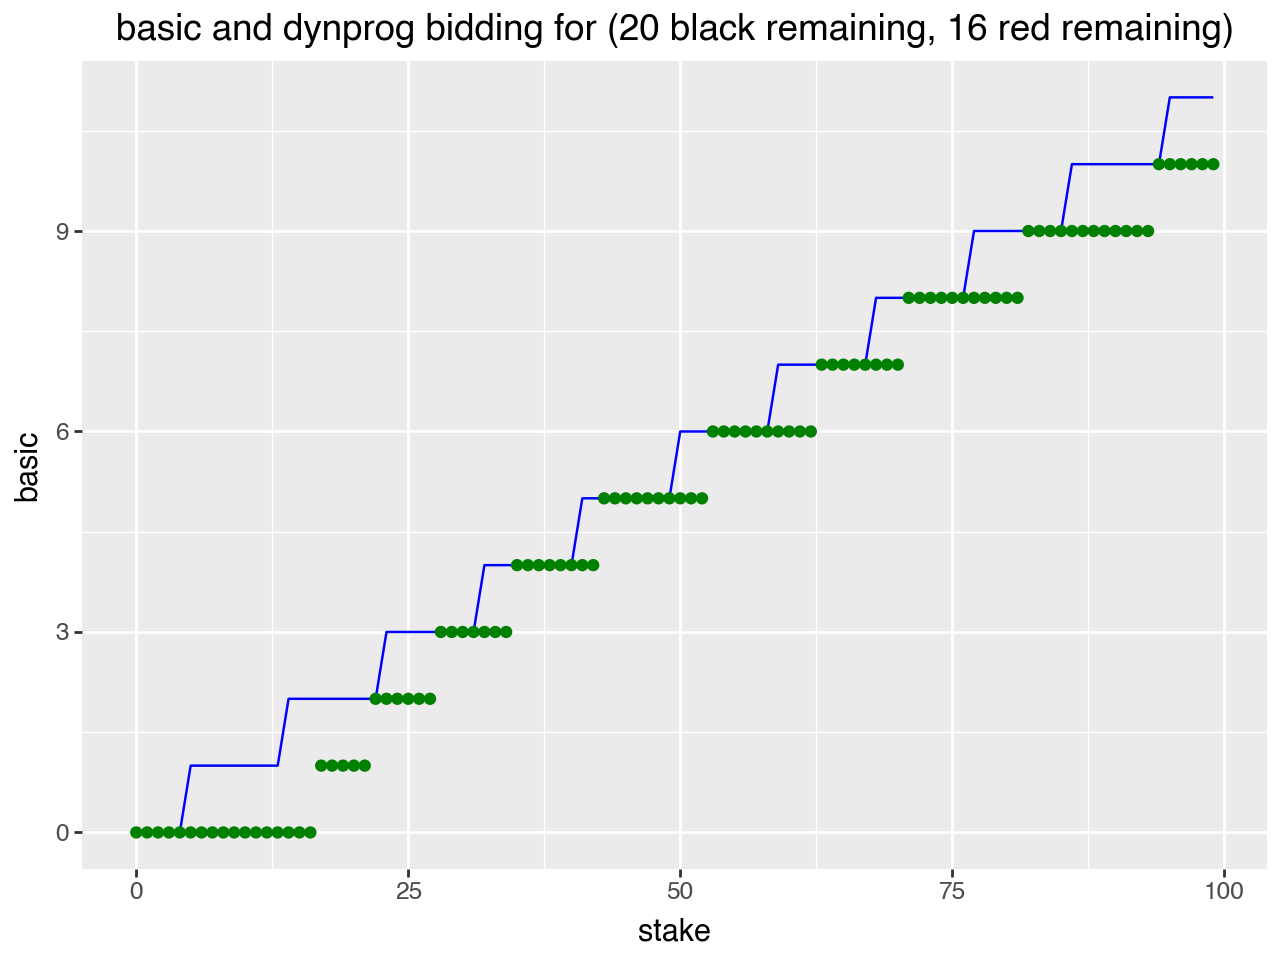

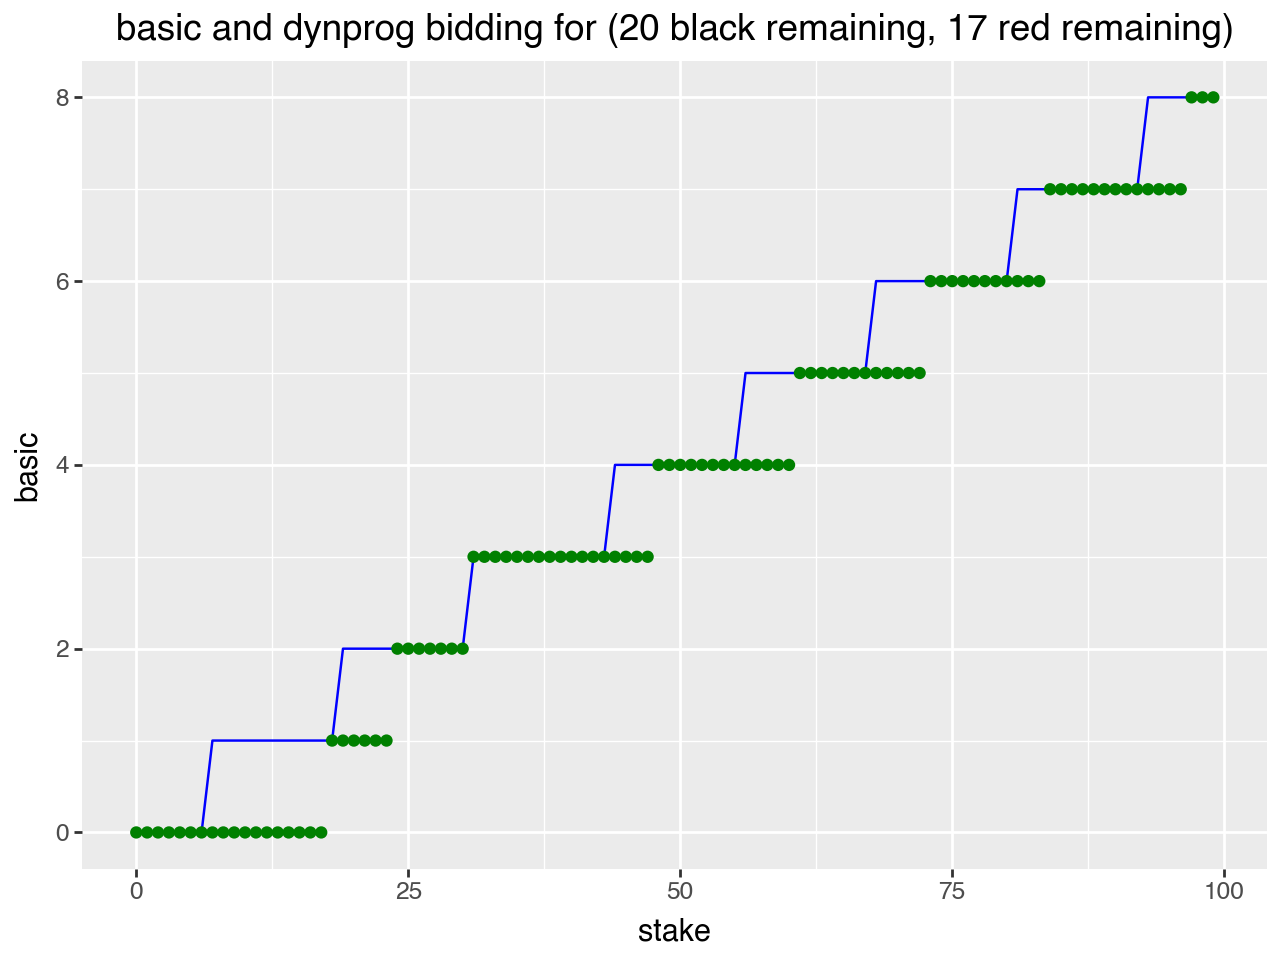

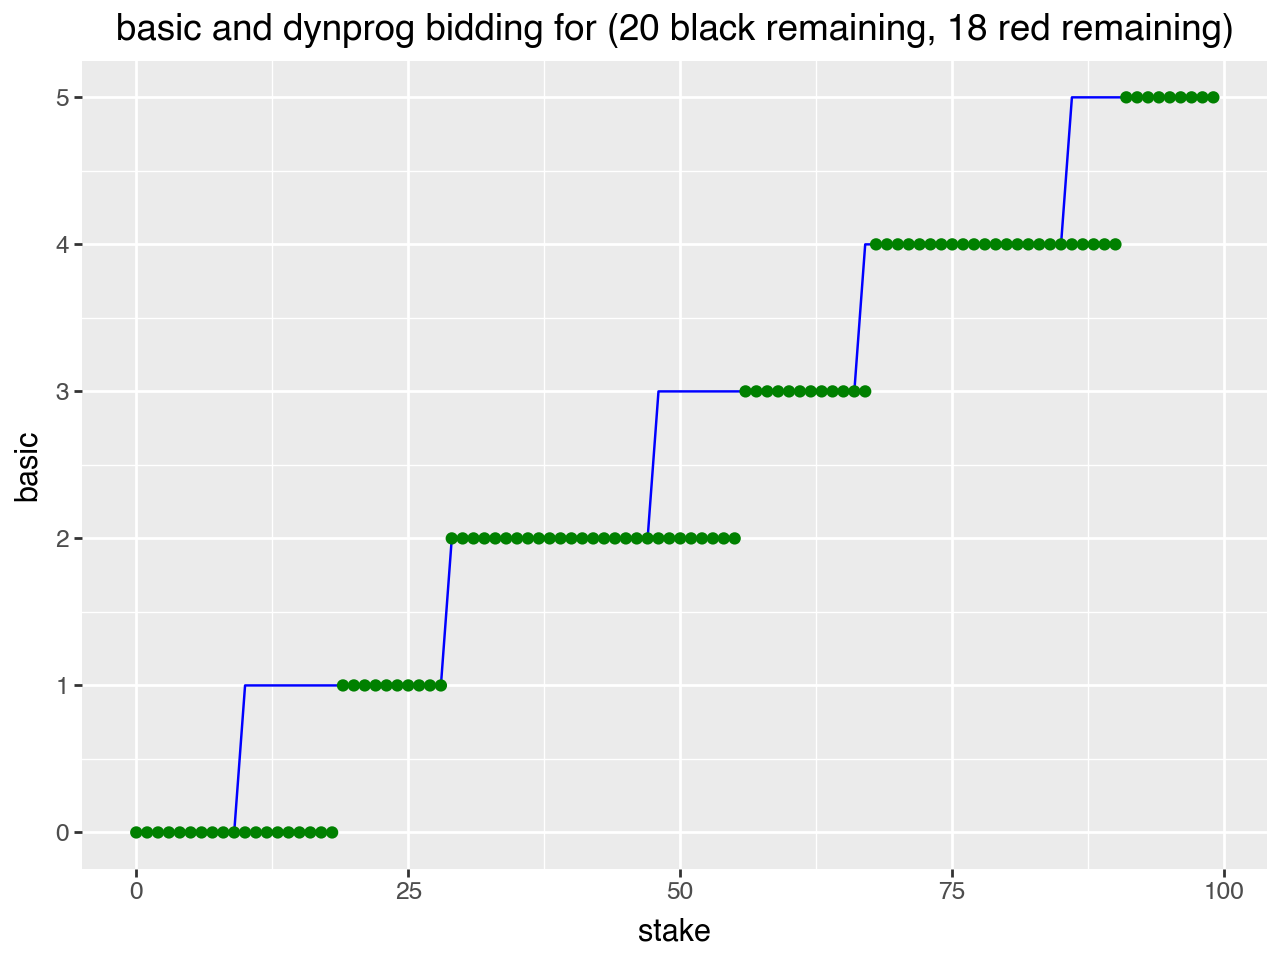

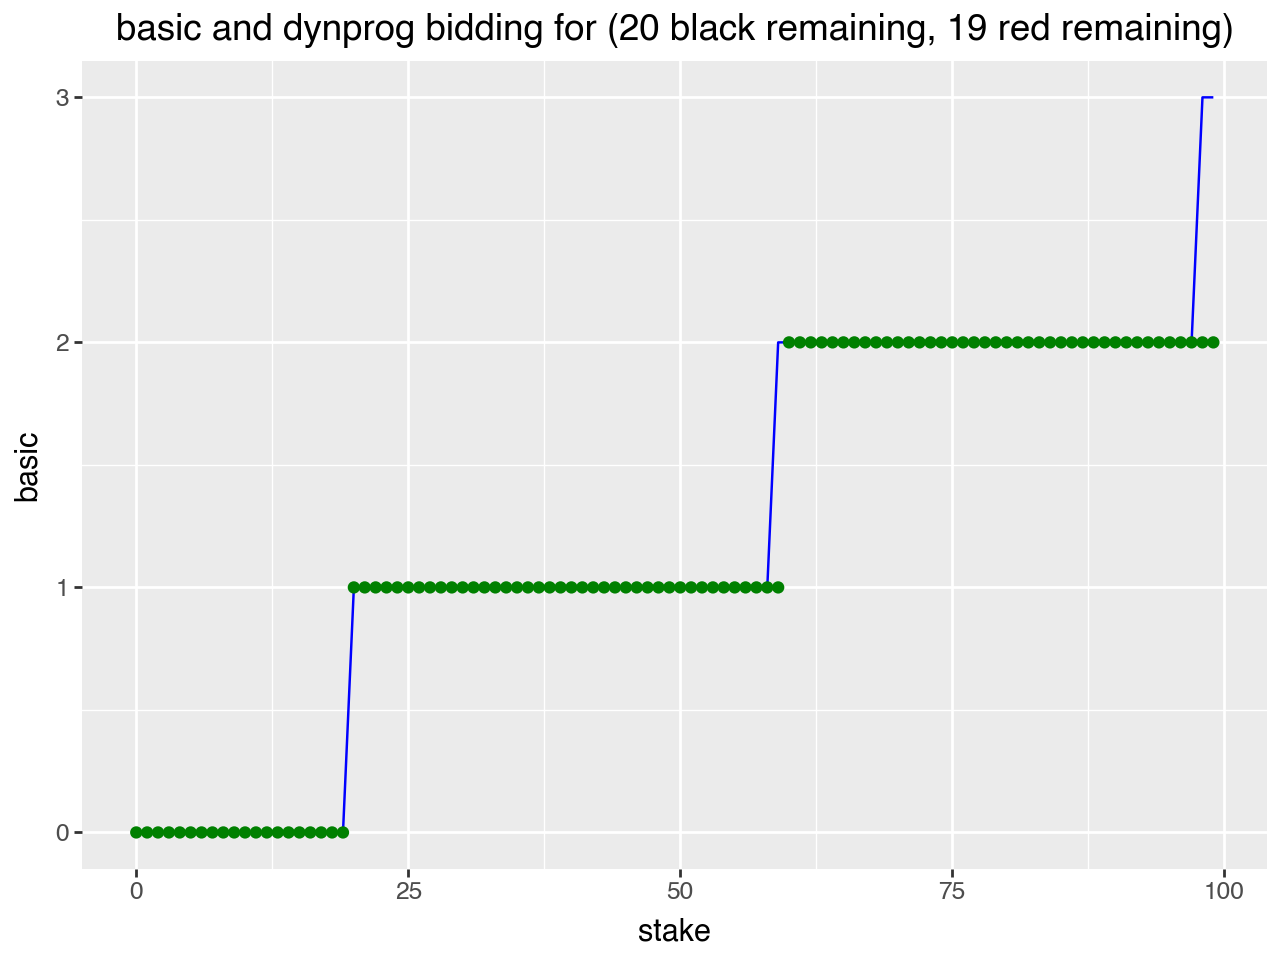

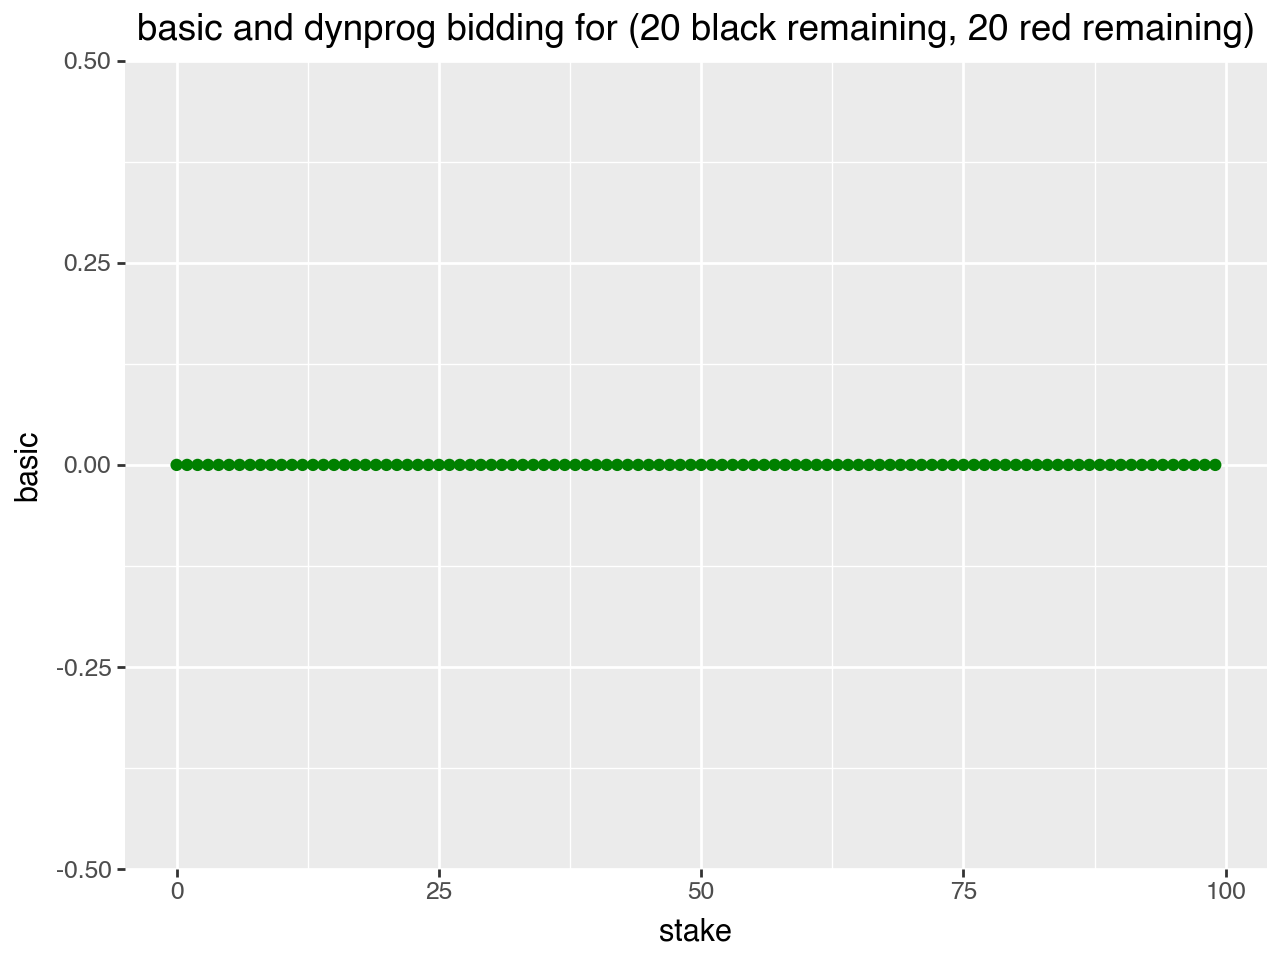

In [37]:
for i in range(21):
    display(plot_comparative_strategies(20, i))